# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

In [4]:
pd.set_option('display.max_columns', None)

## Settings

In [5]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [6]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

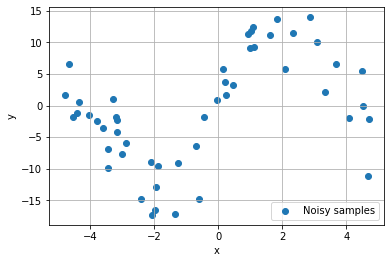

In [7]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

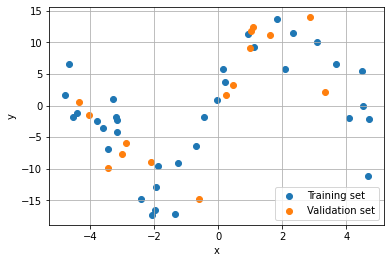

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [9]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [10]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [11]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

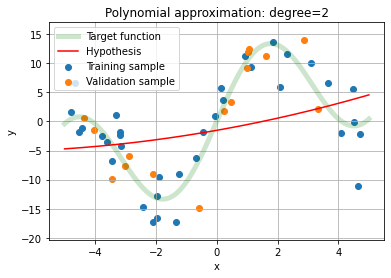

In [12]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

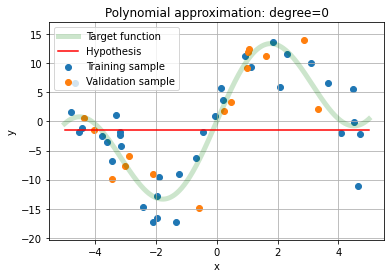

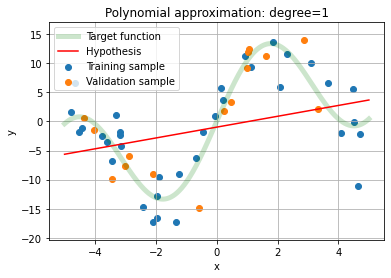

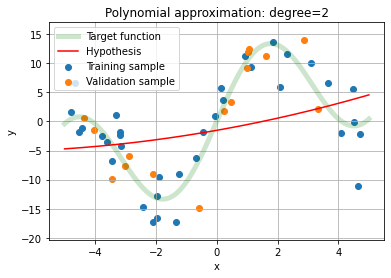

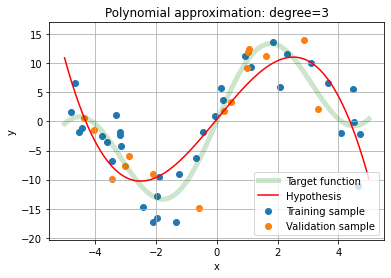

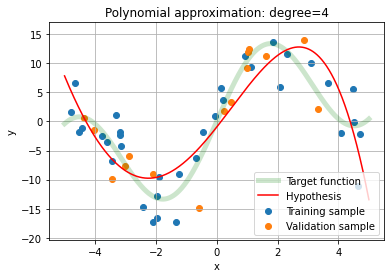

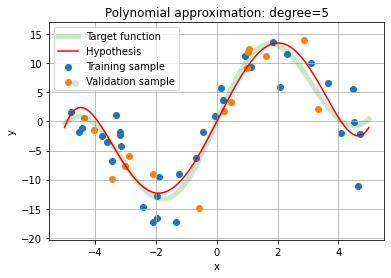

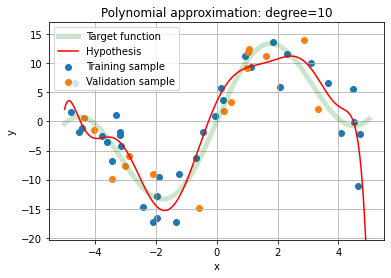

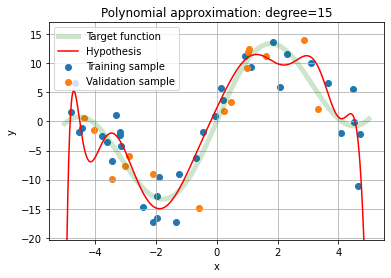

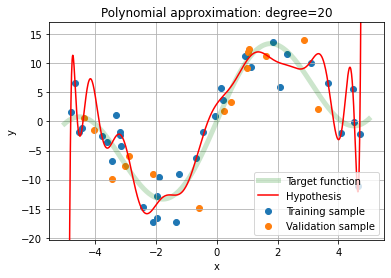

In [13]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

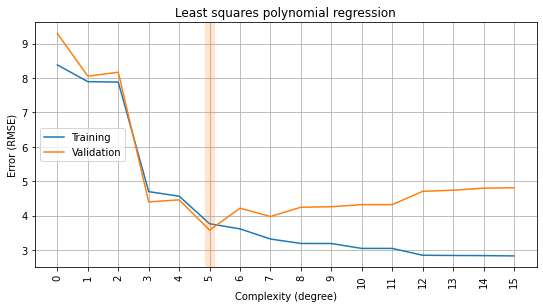

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [15]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

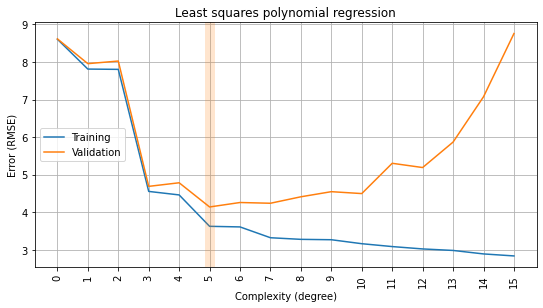

In [16]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [17]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

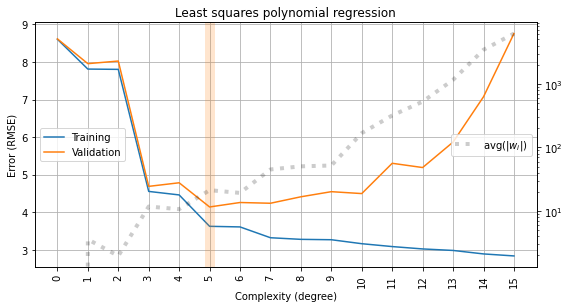

In [18]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

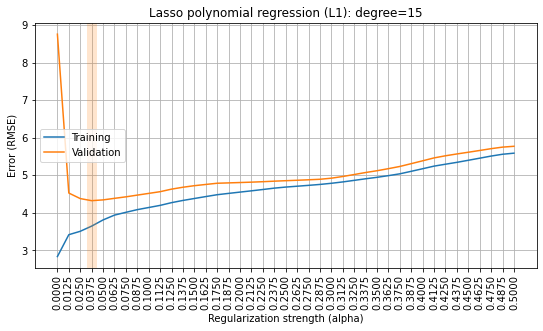

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

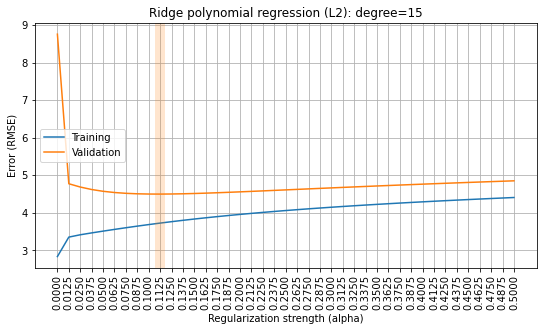

In [20]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [21]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [22]:
df_diabetes = X_diabetes.copy()
df_diabetes['target'] = y_diabetes
df_diabetes.corr().sort_values(by='target', ascending=False)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
target,0.187889,0.043062,0.586450,0.441484,0.212022,0.174054,-0.394789,0.430453,0.565883,0.382483,1.000000
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062


In [23]:
diabetes_features = ['bmi', 's5', 'bp', 's4', 's3', 's6']
diabetes_features

['bmi', 's5', 'bp', 's4', 's3', 's6']

сначала разделим датасет на train / test части в соотношении 70 / 30

In [24]:
X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(X_diabetes, y_diabetes, 
                                                                                        random_state=SEED, 
                                                                                        test_size=0.3)

In [25]:
print(f'Train features: {X_diabetes_train.shape}')
print(f'Train taget: {y_diabetes_train.shape}')

print(f'Test features: {X_diabetes_test.shape}')
print(f'Test taget: {y_diabetes_test.shape}')

Train features: (309, 10)
Train taget: (309, 1)
Test features: (133, 10)
Test taget: (133, 1)


разделение данных на трейн и тест прошло успешно

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [26]:
%%time
rmse_train_diabetes = []
rmse_test_diabetes = []
for custom_degree in DEGREES[1:]:
    print(f'Start generating the features for {custom_degree} polynomial degree...')
    # feature engineering using polynomial functionality
    poly = PolynomialFeatures(degree=custom_degree)
    X_diabetes_train_poly = poly.fit_transform(X_diabetes_train[diabetes_features])
    X_diabetes_test_poly = poly.transform(X_diabetes_test[diabetes_features])
    print('Features generated.')
    
    # learn simple liner regression model (no regularization and no cross-validation on this step)
    lr_model = LinearRegression()
    lr_model.fit(X_diabetes_train_poly, y_diabetes_train)
    
    # make predictions
    train_pred_poly = lr_model.predict(X_diabetes_train_poly)
    test_pred_poly = lr_model.predict(X_diabetes_test_poly)
    
    # calculate RMSE
    rmse_train_poly = mean_squared_error(y_diabetes_train, train_pred_poly) ** 0.5
    rmse_test_poly = mean_squared_error(y_diabetes_test, test_pred_poly) ** 0.5
    rmse_train_diabetes.append(rmse_train_poly)
    rmse_test_diabetes.append(rmse_test_poly)
    print(f'RMSE for train dataset: {rmse_train_poly:.4f}')
    print(f'RMSE for test dataset: {rmse_test_poly:.4f}\n')

Start generating the features for 1 polynomial degree...
Features generated.
RMSE for train dataset: 55.6635
RMSE for test dataset: 53.5992

Start generating the features for 2 polynomial degree...
Features generated.
RMSE for train dataset: 53.1481
RMSE for test dataset: 56.4375

Start generating the features for 3 polynomial degree...
Features generated.
RMSE for train dataset: 55.2078
RMSE for test dataset: 78.8267

Start generating the features for 4 polynomial degree...
Features generated.
RMSE for train dataset: 44.2474
RMSE for test dataset: 204.5847

Start generating the features for 5 polynomial degree...
Features generated.
RMSE for train dataset: 0.0000
RMSE for test dataset: 1592.0119

Start generating the features for 6 polynomial degree...
Features generated.
RMSE for train dataset: 0.0000
RMSE for test dataset: 1527.5294

Start generating the features for 7 polynomial degree...
Features generated.
RMSE for train dataset: 0.0000
RMSE for test dataset: 1530.5190

Start gen

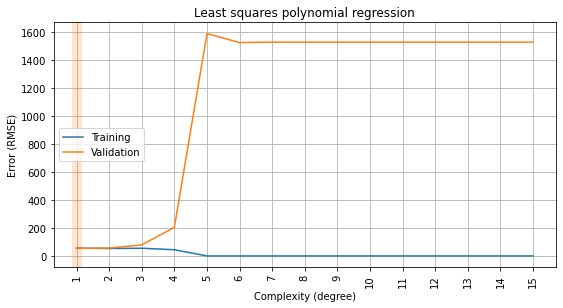

In [27]:
plot_fitting_graph(DEGREES[1:], 
                   rmse_train_diabetes, 
                   rmse_test_diabetes, 
                   xlabel='Complexity (degree)', 
                   ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

In [28]:
DEGREES[1:][np.argmin(rmse_test_diabetes)]

1

что интересно, RMSE (корень из среднеквадратичной ошибки) уже при степени равной 2 на тесте ниже, чем на трейне, т.е. модель уже переобучается, а начина с 3 степени этот разрыв начинает все больше и больше возрастать, а на 6 степени модель просто полностью запоминает точки, т.е. функция с этой степенью полностью проходит через все точки и отклонение на трейне равно 0, а ошибка на тесте просто огромная, потому что запоминая одни данные, невозможно предсказать другие

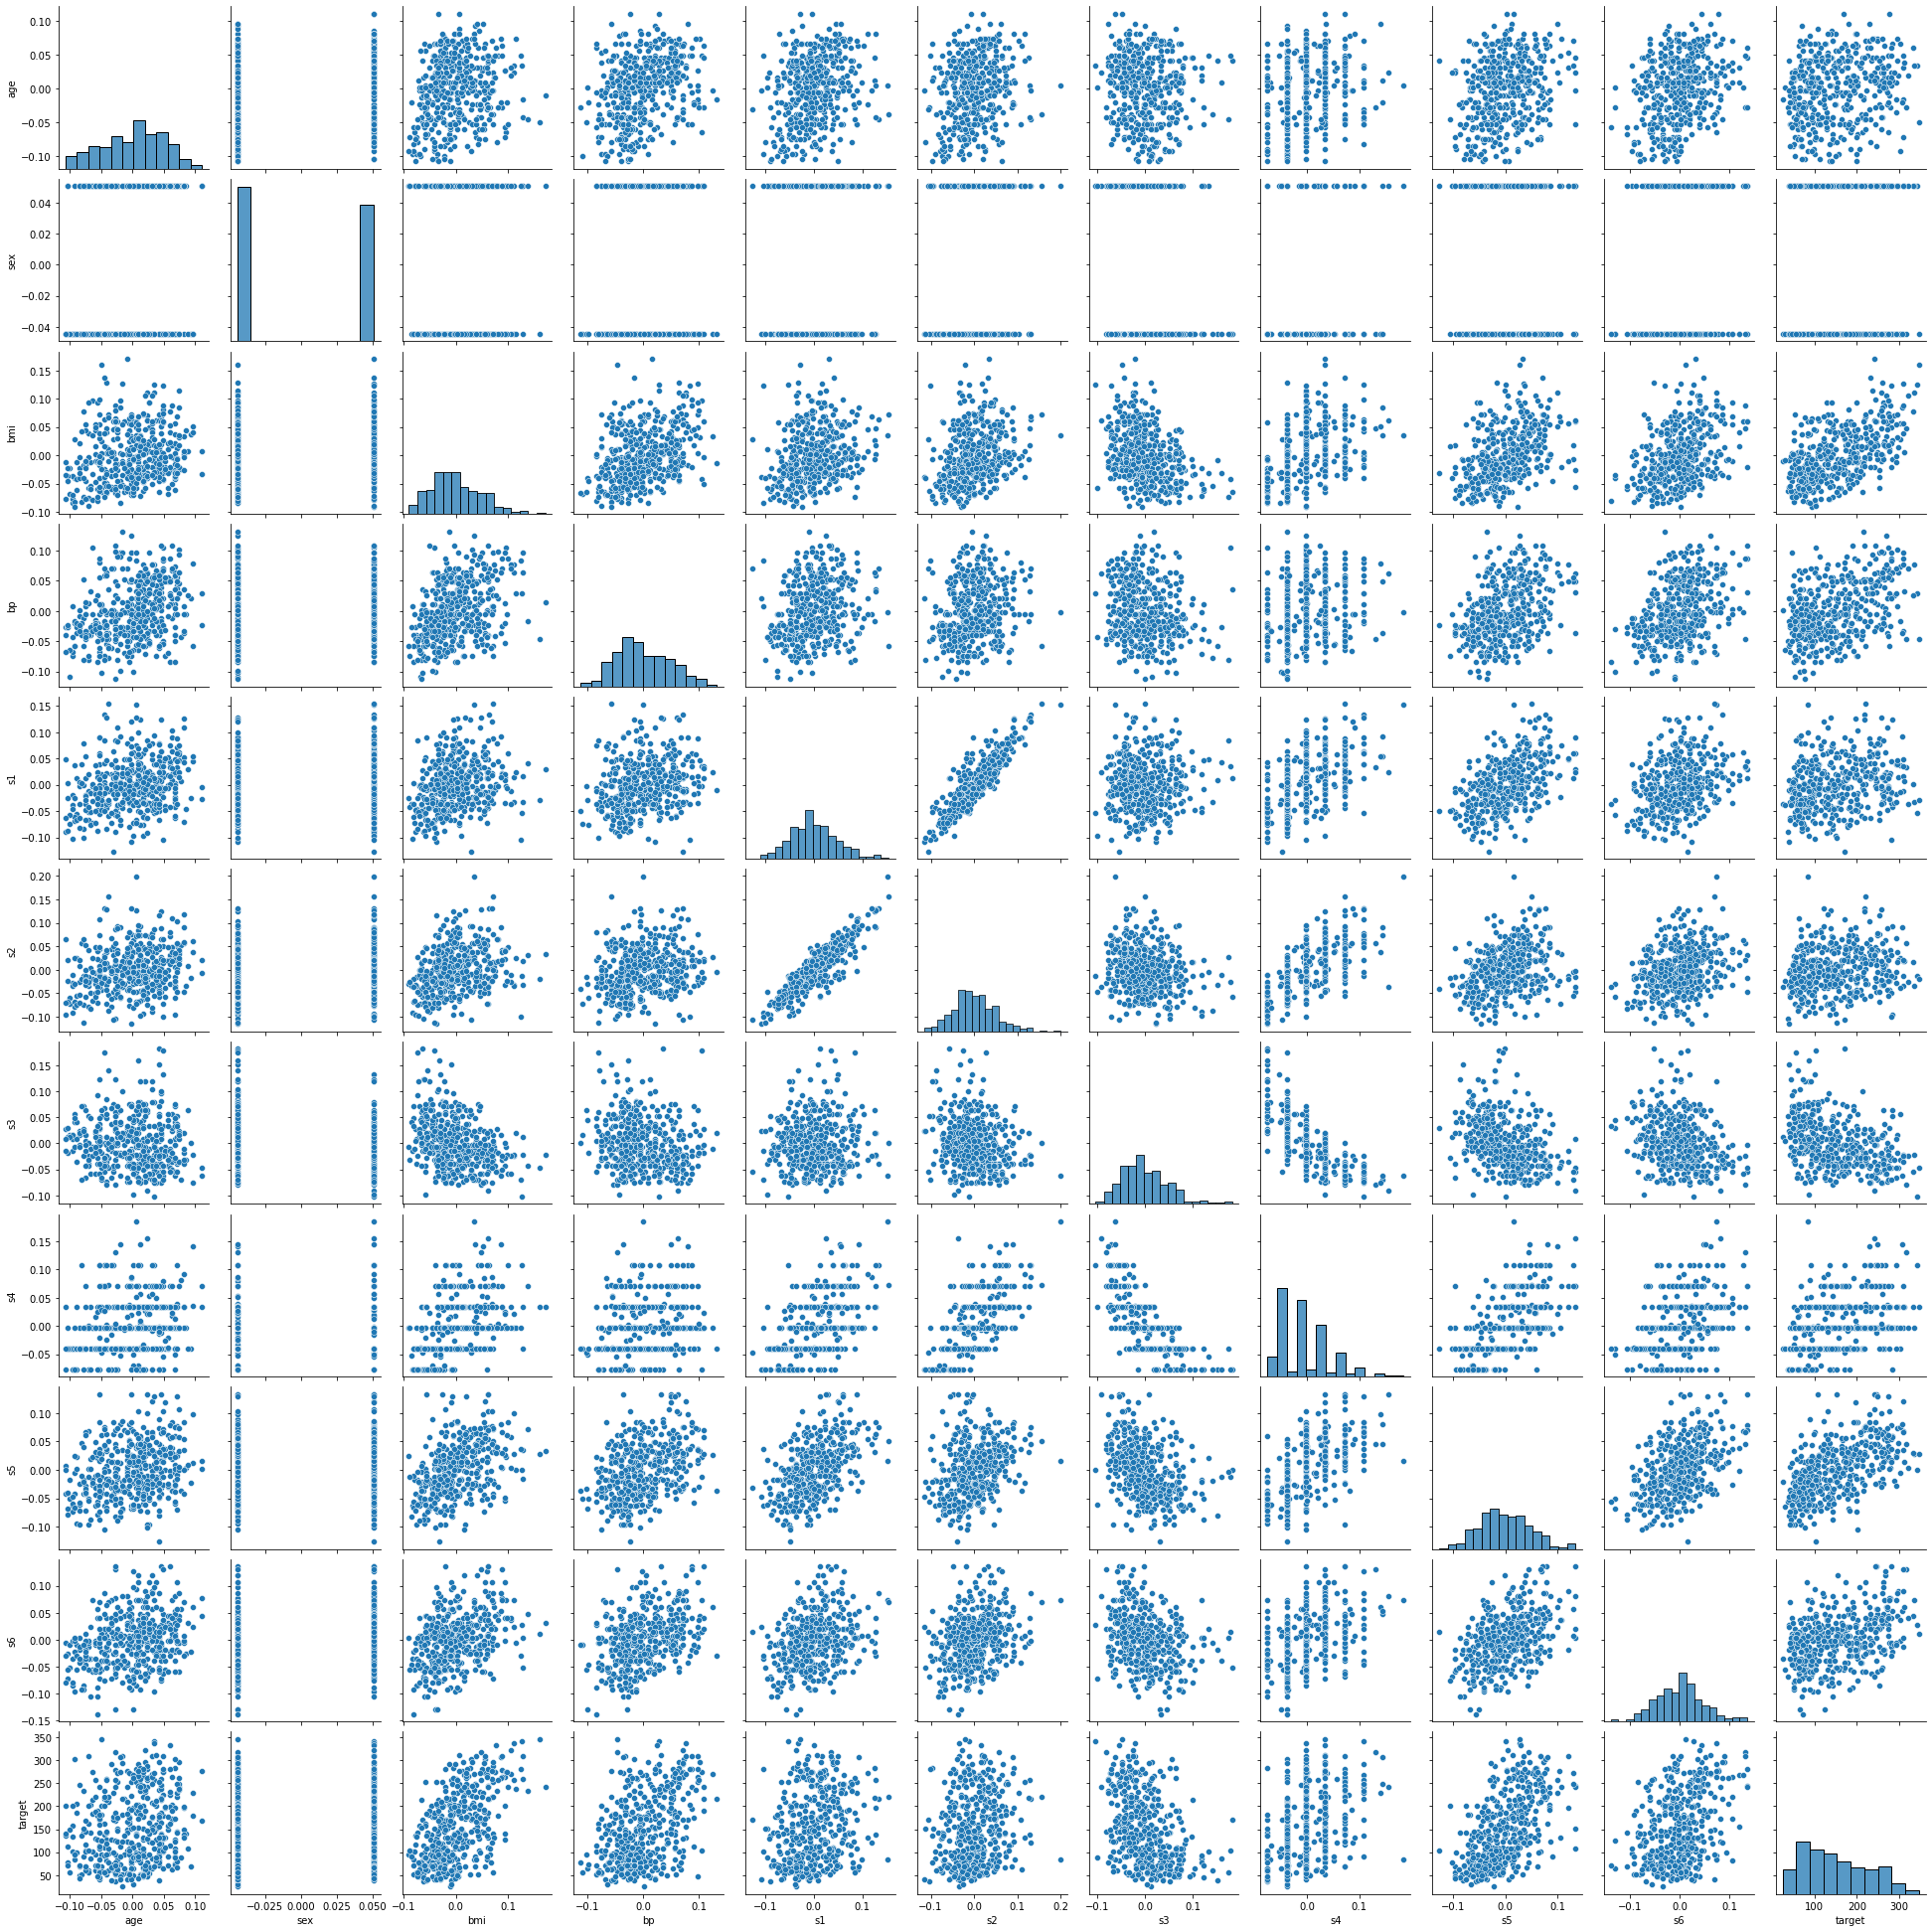

In [29]:
sns.pairplot(df_diabetes)
plt.show()

если посмотреть на таргет, то в целом большинство фичей имеют либо достаточно рассеянные распределения, очень грубо возможно некоторые можно было бы выразить через простую прямую линейную зависимость, возможн исключение составит s3, но в целом не удивительно, что полиномы сразу выбивают слабое качество

попробуем применить кросс-валидацию, посмотрим на результаты обучения с ней

In [30]:
%%time
rmse_train_diabetes = []
rmse_test_diabetes = []
for custom_degree in DEGREES[1:]:
    print(f'Start generating the features for {custom_degree} polynomial degree...')
    # feature engineering using polynomial functionality
    poly = PolynomialFeatures(degree=custom_degree)
    X_diabetes_poly = poly.fit_transform(X_diabetes[diabetes_features])
    print('Features generated.')
    
    # learn simple liner regression model (no regularization on this step)
    lr_model = LinearRegression()
    results = cross_validate(lr_model, 
                             X_diabetes_poly, 
                             y_diabetes, 
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')    

    
    # calculate RMSE
    rmse_train_poly = -np.mean(results['train_score'])
    rmse_test_poly = -np.mean(results['test_score'])
    rmse_train_diabetes.append(rmse_train_poly)
    rmse_test_diabetes.append(rmse_test_poly)
    print(f'RMSE for train dataset: {rmse_train_poly:.4f}')
    print(f'RMSE for test dataset: {rmse_test_poly:.4f}\n')

Start generating the features for 1 polynomial degree...
Features generated.
RMSE for train dataset: 54.6739
RMSE for test dataset: 55.5003

Start generating the features for 2 polynomial degree...
Features generated.
RMSE for train dataset: 52.7516
RMSE for test dataset: 56.9868

Start generating the features for 3 polynomial degree...
Features generated.
RMSE for train dataset: 56.6226
RMSE for test dataset: 77.1722

Start generating the features for 4 polynomial degree...
Features generated.
RMSE for train dataset: 48.4024
RMSE for test dataset: 242.5755

Start generating the features for 5 polynomial degree...
Features generated.
RMSE for train dataset: 0.0000
RMSE for test dataset: 3450.1558

Start generating the features for 6 polynomial degree...
Features generated.
RMSE for train dataset: 0.0000
RMSE for test dataset: 2776.3683

Start generating the features for 7 polynomial degree...
Features generated.
RMSE for train dataset: 0.0000
RMSE for test dataset: 2764.6384

Start gen

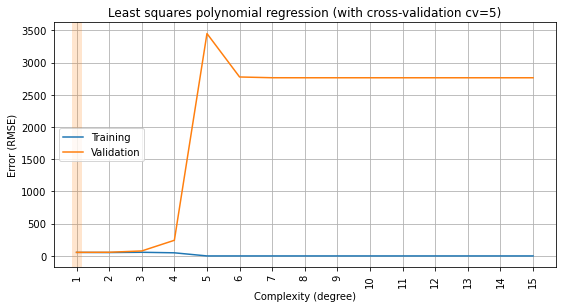

In [31]:
plot_fitting_graph(DEGREES[1:], 
                   rmse_train_diabetes, 
                   rmse_test_diabetes, 
                   xlabel='Complexity (degree)', 
                   ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression (with cross-validation cv=5)')

In [32]:
DEGREES[1:][np.argmin(rmse_test_diabetes)]

1

в целом результаты те же, если неверно подобрана исходная функция, валидация не сыграет решающей роли

для лучшей функции подадим модели все фичи и рассчитаем метрики:

In [33]:
best_degree = DEGREES[1:][np.argmin(rmse_test_diabetes)]
# apply polinomial feature enginering
poly = PolynomialFeatures(degree=best_degree)
X_diabetes_train_poly = poly.fit_transform(X_diabetes_train)
X_diabetes_test_poly = poly.transform(X_diabetes_test)

# get metrics without cross-validation
lr_model = LinearRegression()
lr_model.fit(X_diabetes_train_poly, y_diabetes_train)

# make predictions and mesure rmse
train_pred = lr_model.predict(X_diabetes_train_poly)
test_pred = lr_model.predict(X_diabetes_test_poly)
rmse_fin_train = mean_squared_error(y_diabetes_train, train_pred) ** 0.5
rmse_fin_test = mean_squared_error(y_diabetes_test, test_pred) ** 0.5
diff_pct = rmse_fin_test / rmse_fin_train - 1
print(f'RMSE for {best_degree} polynomial degrees without cross-validation:\
\n on train is {rmse_fin_train:.4f}, on test is {rmse_fin_test:.4f}, percent of difference: {diff_pct:.2%}.\n')

# apply cross-validation
lr_model = LinearRegression()
poly = PolynomialFeatures(degree=best_degree)
X_diabetes_poly = poly.fit_transform(X_diabetes)
results = cross_validate(lr_model, 
                         X_diabetes_poly, 
                         y_diabetes, 
                         cv=5,
                         return_train_score=True,
                         scoring='neg_root_mean_squared_error')

# get rmse from cross-validated datasets
rmse_fin_cv_train = -np.mean(results['train_score'])
rmse_fin_cv_test = -np.mean(results['test_score'])
diff_pct_cv = rmse_fin_cv_test / rmse_fin_cv_train - 1
print(f'RMSE for {best_degree} polynomial degrees with cross-validation:\
\n on train is {rmse_fin_cv_train:.4f}, on test is {rmse_fin_cv_test:.4f}, percent of difference: {diff_pct_cv:.2%}.')

RMSE for 1 polynomial degrees without cross-validation:
 on train is 54.0744, on test is 53.1200, percent of difference: -1.76%.

RMSE for 1 polynomial degrees with cross-validation:
 on train is 53.3415, on test is 54.6917, percent of difference: 2.53%.


итого rmse на трейне и тесте отличается не более 2,53% (при кросс-валидации), переобучения при текущем уровне не происходит

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

по причине низкой производительности будем проводить эксперименты на том же наборе фичей, которые имеют высокую зависимость с таргетом

In [34]:
poly = PolynomialFeatures(degree=15)
X_diabetes_train_poly = poly.fit_transform(X_diabetes_train[diabetes_features])
X_diabetes_test_poly = poly.transform(X_diabetes_test[diabetes_features])

In [35]:
display(ALPHAS)

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
       0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
       0.3   , 0.3125, 0.325 , 0.3375, 0.35  , 0.3625, 0.375 , 0.3875,
       0.4   , 0.4125, 0.425 , 0.4375, 0.45  , 0.4625, 0.475 , 0.4875,
       0.5   ])

#### L1

In [36]:
%%time
l1_rmse_train = []
l1_rmse_test = []
l1_coefficients = []

for a in ALPHAS[1:]: # alpha = 0 means usig LinearRegression
    lasso_model = Lasso(alpha=a)
    lasso_model.fit(X_diabetes_train_poly, y_diabetes_train)
    
    train_pred_poly = lasso_model.predict(X_diabetes_train_poly)
    test_pred_poly = lasso_model.predict(X_diabetes_test_poly)
    
    rmse_train = mean_squared_error(y_diabetes_train, train_pred_poly) ** 0.5
    rmse_test = mean_squared_error(y_diabetes_test, test_pred_poly) ** 0.5
    
    l1_rmse_train.append(rmse_train)
    l1_rmse_test.append(rmse_test)
    l1_coefficients.append(lasso_model.coef_.tolist())
    diff_pct = rmse_test / rmse_train - 1
    
    print(f'Current alpha is {a:.4f}, RMSE on train is {rmse_train:.4f}, RMSE on test is {rmse_test:.4f}, difference is {diff_pct:.2%}.')

Current alpha is 0.0125, RMSE on train is 54.9587, RMSE on test is 53.1493, difference is -3.29%.
Current alpha is 0.0250, RMSE on train is 55.7004, RMSE on test is 53.5788, difference is -3.81%.
Current alpha is 0.0375, RMSE on train is 55.7464, RMSE on test is 53.5987, difference is -3.85%.
Current alpha is 0.0500, RMSE on train is 55.8104, RMSE on test is 53.6375, difference is -3.89%.
Current alpha is 0.0625, RMSE on train is 55.8248, RMSE on test is 53.6084, difference is -3.97%.
Current alpha is 0.0750, RMSE on train is 55.8391, RMSE on test is 53.5781, difference is -4.05%.
Current alpha is 0.0875, RMSE on train is 55.8559, RMSE on test is 53.5506, difference is -4.13%.
Current alpha is 0.1000, RMSE on train is 55.8753, RMSE on test is 53.5260, difference is -4.20%.
Current alpha is 0.1125, RMSE on train is 55.8972, RMSE on test is 53.5043, difference is -4.28%.
Current alpha is 0.1250, RMSE on train is 55.9218, RMSE on test is 53.4854, difference is -4.36%.
Current alpha is 0.1

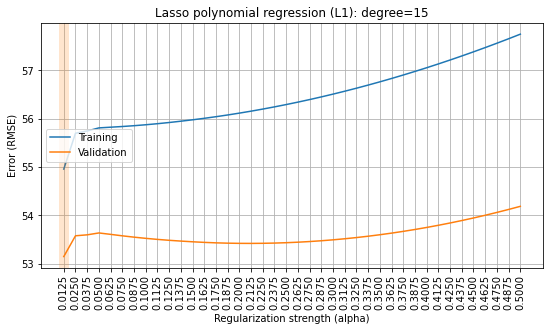

In [37]:
plot_fitting_graph(ALPHAS[1:], l1_rmse_train, l1_rmse_test,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

лучшие результаты получены при alpha=0.0125, что интересно, даже при такой большой степени полинома модель не переобучается, посмотрим на коэффициенты, соберем их в отдельный датафрейм, где колонки это соответствующие alpha коэффициенты, использованные в модели

In [38]:
result_dict = {}
for i in range(len(l1_coefficients)):
    coef = ALPHAS[i+1]
    result_dict[coef] = l1_coefficients[i]
l1_results_df = pd.DataFrame(result_dict)
l1_results_df.head(20)

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,558.931608,596.967430,594.130857,591.310977,589.728169,588.188956,586.649969,585.110995,583.572021,582.032803,580.491658,578.756741,576.936155,575.115568,573.294982,571.474396,569.653809,567.833223,566.012637,564.192051,562.371464,560.550878,558.730292,556.909705,555.089119,553.268533,551.447947,549.627360,547.806774,545.986188,544.165602,542.345015,540.524429,538.703843,536.883256,535.062670,533.242084,531.421498,529.600911,527.780325
2,404.418773,381.623583,367.504620,353.538235,351.601457,350.265504,348.930866,347.596297,346.261728,344.927570,343.596653,341.885995,340.009531,338.133066,336.256601,334.380136,332.503671,330.627206,328.750741,326.874276,324.997811,323.121347,321.244882,319.368417,317.491952,315.615487,313.739022,311.862557,309.986092,308.109627,306.233163,304.356698,302.480233,300.603768,298.727303,296.850838,294.974373,293.097908,291.221443,289.344979
3,337.523535,325.037473,323.165650,321.280581,318.090326,314.848633,311.607059,308.365491,305.123923,301.882537,298.642579,295.138053,291.495638,287.853224,284.210809,280.568395,276.925981,273.283566,269.641152,265.998737,262.356323,258.713908,255.071494,251.429079,247.786665,244.144251,240.501836,236.859422,233.217007,229.574593,225.932178,222.289764,218.647349,215.004935,211.362521,207.720106,204.077692,200.435277,196.792863,193.150448
4,-122.610625,-70.531661,-35.928805,-1.522788,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-338.955838,-287.026289,-264.061999,-241.177243,-236.828061,-233.333057,-229.837879,-226.342693,-222.847506,-219.352407,-215.857999,-212.214726,-208.486707,-204.758688,-201.030669,-197.302650,-193.574631,-189.846612,-186.118593,-182.390574,-178.662555,-174.934536,-171.206517,-167.478498,-163.750479,-160.022460,-156.294441,-152.566422,-148.838403,-145.110384,-141.382365,-137.654346,-133.926327,-130.198308,-126.470289,-122.742271,-119.014252,-115.286233,-111.558214,-107.830195
6,20.234843,25.593786,19.987302,14.372328,12.284751,10.343482,8.401521,6.459523,4.517526,2.575339,0.631662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1017.831687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,26.844630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [39]:
display(l1_results_df.shape)

(54264, 40)

In [40]:
l1_results_df[l1_results_df[0.0125] > 0]

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
1,558.931608,596.967430,594.130857,591.310977,589.728169,588.188956,586.649969,585.110995,583.572021,582.032803,580.491658,578.756741,576.936155,575.115568,573.294982,571.474396,569.653809,567.833223,566.012637,564.192051,562.371464,560.550878,558.730292,556.909705,555.089119,553.268533,551.447947,549.627360,547.806774,545.986188,544.165602,542.345015,540.524429,538.703843,536.883256,535.062670,533.242084,531.421498,529.600911,527.780325
2,404.418773,381.623583,367.504620,353.538235,351.601457,350.265504,348.930866,347.596297,346.261728,344.927570,343.596653,341.885995,340.009531,338.133066,336.256601,334.380136,332.503671,330.627206,328.750741,326.874276,324.997811,323.121347,321.244882,319.368417,317.491952,315.615487,313.739022,311.862557,309.986092,308.109627,306.233163,304.356698,302.480233,300.603768,298.727303,296.850838,294.974373,293.097908,291.221443,289.344979
3,337.523535,325.037473,323.165650,321.280581,318.090326,314.848633,311.607059,308.365491,305.123923,301.882537,298.642579,295.138053,291.495638,287.853224,284.210809,280.568395,276.925981,273.283566,269.641152,265.998737,262.356323,258.713908,255.071494,251.429079,247.786665,244.144251,240.501836,236.859422,233.217007,229.574593,225.932178,222.289764,218.647349,215.004935,211.362521,207.720106,204.077692,200.435277,196.792863,193.150448
6,20.234843,25.593786,19.987302,14.372328,12.284751,10.343482,8.401521,6.459523,4.517526,2.575339,0.631662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1017.831687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,26.844630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,254.645688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,399.790952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
27,654.900885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


54264 фичи:) в целом уже видно, что часть коэфициентов модель занулила уже на первой итерации, некоторые постепенно нивелировались путем снижения их веса и также становились нулями

In [41]:
l1_results_df[l1_results_df[0.5000] > 0]

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
1,558.931608,596.967430,594.130857,591.310977,589.728169,588.188956,586.649969,585.110995,583.572021,582.032803,580.491658,578.756741,576.936155,575.115568,573.294982,571.474396,569.653809,567.833223,566.012637,564.192051,562.371464,560.550878,558.730292,556.909705,555.089119,553.268533,551.447947,549.627360,547.806774,545.986188,544.165602,542.345015,540.524429,538.703843,536.883256,535.062670,533.242084,531.421498,529.600911,527.780325
2,404.418773,381.623583,367.504620,353.538235,351.601457,350.265504,348.930866,347.596297,346.261728,344.927570,343.596653,341.885995,340.009531,338.133066,336.256601,334.380136,332.503671,330.627206,328.750741,326.874276,324.997811,323.121347,321.244882,319.368417,317.491952,315.615487,313.739022,311.862557,309.986092,308.109627,306.233163,304.356698,302.480233,300.603768,298.727303,296.850838,294.974373,293.097908,291.221443,289.344979
3,337.523535,325.037473,323.165650,321.280581,318.090326,314.848633,311.607059,308.365491,305.123923,301.882537,298.642579,295.138053,291.495638,287.853224,284.210809,280.568395,276.925981,273.283566,269.641152,265.998737,262.356323,258.713908,255.071494,251.429079,247.786665,244.144251,240.501836,236.859422,233.217007,229.574593,225.932178,222.289764,218.647349,215.004935,211.362521,207.720106,204.077692,200.435277,196.792863,193.150448


в итоге в модели остались только три фичи, которые очевидно имеют очень большие коэффициенты, но тем не менее благодаря регуляризации модель все же не переобучается

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
1,558.931608,596.967430,594.130857,591.310977,589.728169,588.188956,586.649969,585.110995,583.572021,582.032803,580.491658,578.756741,576.936155,575.115568,573.294982,571.474396,569.653809,567.833223,566.012637,564.192051,562.371464,560.550878,558.730292,556.909705,555.089119,553.268533,551.447947,549.627360,547.806774,545.986188,544.165602,542.345015,540.524429,538.703843,536.883256,535.062670,533.242084,531.421498,529.600911,527.780325
2,404.418773,381.623583,367.504620,353.538235,351.601457,350.265504,348.930866,347.596297,346.261728,344.927570,343.596653,341.885995,340.009531,338.133066,336.256601,334.380136,332.503671,330.627206,328.750741,326.874276,324.997811,323.121347,321.244882,319.368417,317.491952,315.615487,313.739022,311.862557,309.986092,308.109627,306.233163,304.356698,302.480233,300.603768,298.727303,296.850838,294.974373,293.097908,291.221443,289.344979
3,337.523535,325.037473,323.165650,321.280581,318.090326,314.848633,311.607059,308.365491,305.123923,301.882537,298.642579,295.138053,291.495638,287.853224,284.210809,280.568395,276.925981,273.283566,269.641152,265.998737,262.356323,258.713908,255.071494,251.429079,247.786665,244.144251,240.501836,236.859422,233.217007,229.574593,225.932178,222.289764,218.647349,215.004935,211.362521,207.720106,204.077692,200.435277,196.792863,193.150448
6,20.234843,25.593786,19.987302,14.372328,12.284751,10.343482,8.401521,6.459523,4.517526,2.575339,0.631662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1017.831687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,26.844630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,254.645688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,399.790952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
27,654.900885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


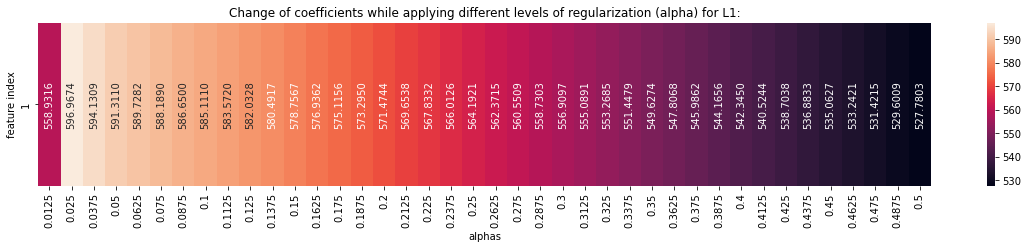

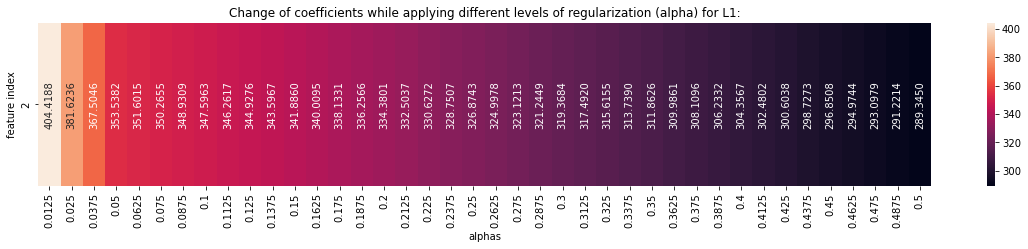

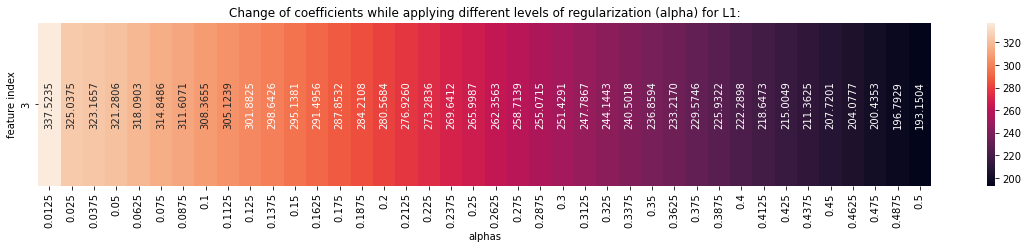

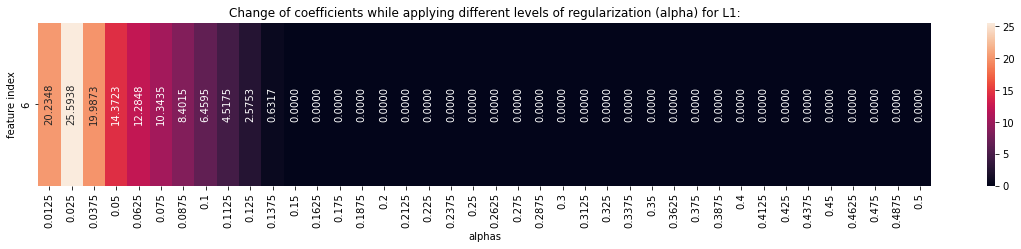

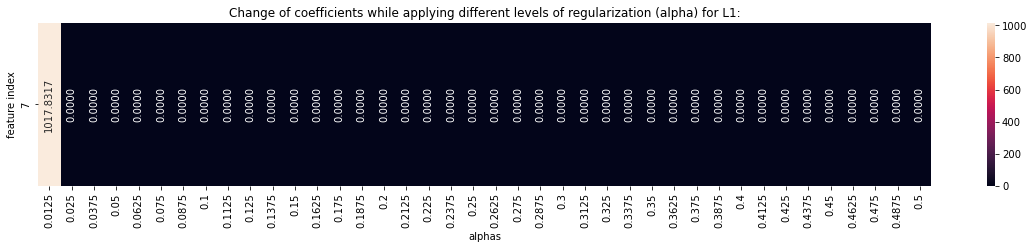

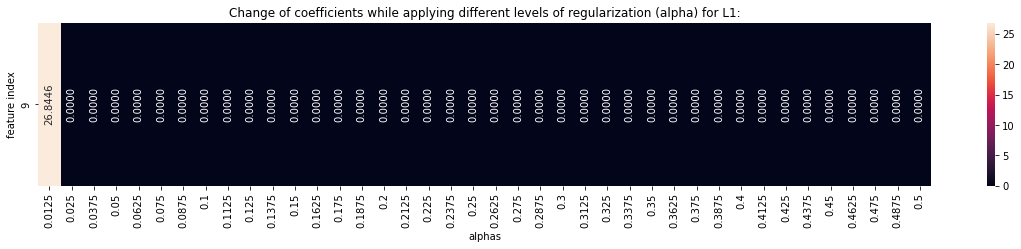

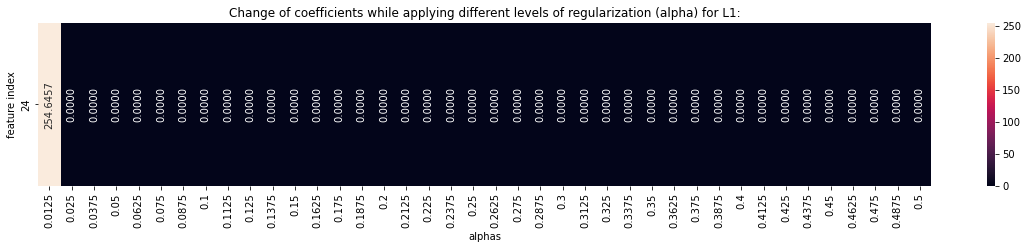

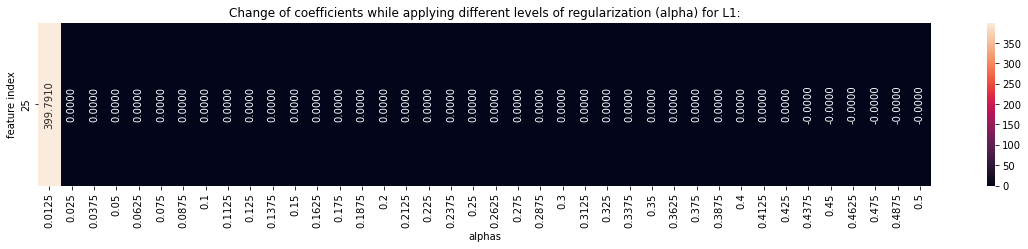

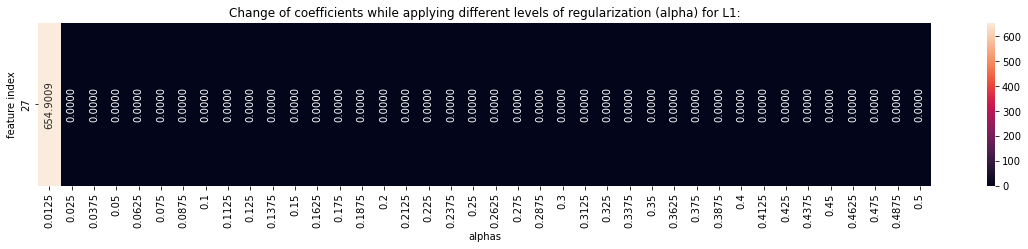

In [42]:
non_null_l1_df = l1_results_df[l1_results_df[0.0125] > 0].sort_values(by=0.0250, ascending=False)
non_null_l1_df.columns = [round(a, 4) for a in non_null_l1_df.columns]
display(non_null_l1_df)

for i in range(non_null_l1_df.shape[0]):
    plt.figure(figsize=(20,3))
    sns.heatmap(pd.DataFrame(non_null_l1_df.iloc[i]).T, annot=True, annot_kws={'rotation': 90}, fmt='.4f')
    plt.title('Change of coefficients while applying different levels of regularization (alpha) for L1:')
    plt.xlabel('alphas')
    plt.ylabel('feature index')
    plt.show()

глядя на heatmap по каждому из ненулевых коэффициентов можно действительно утверждать, что штаф/ограничение к коэффициентам применяется и с увеличением коэффициента регуляризации alpha, коэффициенты снижаются

посмотрим, что будет происходить при использовании L2

#### L2

In [43]:
%%time
l2_rmse_train = []
l2_rmse_test = []
l2_coefficients = []

for a in ALPHAS[1:]: # alpha = 0 means usig LinearRegression
    ridge_model = Ridge(alpha=a)
    ridge_model.fit(X_diabetes_train_poly, y_diabetes_train)
    
    train_pred_poly = ridge_model.predict(X_diabetes_train_poly)
    test_pred_poly = ridge_model.predict(X_diabetes_test_poly)
    
    rmse_train = mean_squared_error(y_diabetes_train, train_pred_poly) ** 0.5
    rmse_test = mean_squared_error(y_diabetes_test, test_pred_poly) ** 0.5
    
    l2_rmse_train.append(rmse_train)
    l2_rmse_test.append(rmse_test)
    l2_coefficients.append(ridge_model.coef_[0].tolist())
    diff_pct = rmse_test / rmse_train - 1
    
    print(f'Current alpha is {a:.4f}, RMSE on train is {rmse_train:.4f}, RMSE on test is {rmse_test:.4f}, difference is {diff_pct:.2%}.')

Current alpha is 0.0125, RMSE on train is 54.8797, RMSE on test is 53.1443, difference is -3.16%.
Current alpha is 0.0250, RMSE on train is 55.1853, RMSE on test is 53.2051, difference is -3.59%.
Current alpha is 0.0375, RMSE on train is 55.3463, RMSE on test is 53.2463, difference is -3.79%.
Current alpha is 0.0500, RMSE on train is 55.4574, RMSE on test is 53.2734, difference is -3.94%.
Current alpha is 0.0625, RMSE on train is 55.5462, RMSE on test is 53.2937, difference is -4.06%.
Current alpha is 0.0750, RMSE on train is 55.6234, RMSE on test is 53.3110, difference is -4.16%.
Current alpha is 0.0875, RMSE on train is 55.6943, RMSE on test is 53.3271, difference is -4.25%.
Current alpha is 0.1000, RMSE on train is 55.7613, RMSE on test is 53.3432, difference is -4.34%.
Current alpha is 0.1125, RMSE on train is 55.8260, RMSE on test is 53.3598, difference is -4.42%.
Current alpha is 0.1250, RMSE on train is 55.8891, RMSE on test is 53.3773, difference is -4.49%.
Current alpha is 0.1

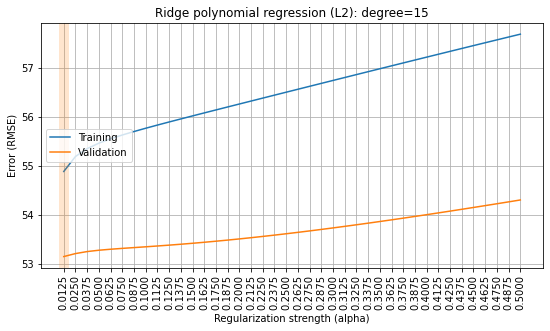

In [44]:
plot_fitting_graph(ALPHAS[1:], l2_rmse_train, l2_rmse_test,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2): degree=15')

лучшие результаты также получены при alpha=0.0125, общая тенденция аналогична L1 регуляризации, но при этом стоит отметить, что % разрыва между тестом и трейном при использовании L2 регуляризации меньше вероятнее всего из-за того, что Ridge Regression не зануляет фичи, тем самым они все также продолжают давать свой вклад в модель, но посмотрим на них нагляднее

In [45]:
result_dict = {}
for i in range(len(l2_coefficients)):
    coef = ALPHAS[i+1]
    result_dict[coef] = l2_coefficients[i]
l2_results_df = pd.DataFrame(result_dict)
l2_results_df.head(20)

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,569.701921,569.286525,563.688495,556.697774,549.270603,541.755297,534.303632,526.988034,519.844061,512.888456,506.127720,499.562544,493.190248,487.006194,481.004627,475.179196,469.523288,464.030227,458.693412,453.506398,448.462948,443.557064,438.782997,434.135260,429.608623,425.198110,420.898991,416.706772,412.617186,408.626184,404.729918,400.924738,397.207175,393.573935,390.021889,386.548060,383.149620,379.823875,376.568262,373.380342
2,407.223203,390.160747,378.119926,368.240921,359.708630,352.151836,345.355103,339.175180,333.508834,328.277811,323.420756,318.888388,314.640411,310.643403,306.869325,303.294422,299.898405,296.663816,293.575539,290.620406,287.786886,285.064835,282.445287,279.920284,277.482737,275.126309,272.845313,270.634632,268.489645,266.406172,264.380414,262.408919,260.488533,258.616373,256.789799,255.006383,253.263893,251.560268,249.893606,248.262146
3,330.198541,326.287664,323.327881,320.631160,318.036307,315.490991,312.976271,310.485519,308.017060,305.571252,303.149215,300.752278,298.381715,296.038646,293.723992,291.438481,289.182652,286.956878,284.761386,282.596275,280.461539,278.357078,276.282718,274.238220,272.223292,270.237600,268.280775,266.352419,264.452114,262.579422,260.733894,258.915073,257.122492,255.355685,253.614183,251.897515,250.205216,248.536822,246.891875,245.269920
4,-146.765443,-110.848193,-86.087437,-66.632881,-50.476960,-36.657295,-24.616343,-13.990796,-4.525049,3.970357,11.641146,18.602509,24.947428,30.752213,36.080348,40.985243,45.512268,49.700289,53.582841,57.189053,60.544373,63.671152,66.589115,69.315751,71.866625,74.255645,76.495281,78.596751,80.570180,82.424728,84.168707,85.809680,87.354544,88.809602,90.180627,91.472918,92.691349,93.840409,94.924241,95.946678
5,-353.548450,-322.308511,-303.148997,-288.939449,-277.527392,-267.969098,-259.754771,-252.570329,-246.204570,-240.506612,-235.363899,-230.689723,-226.415641,-222.486571,-218.857494,-215.491140,-212.356319,-209.426685,-206.679808,-204.096451,-201.660014,-199.356089,-197.172107,-195.097053,-193.121227,-191.236060,-189.433947,-187.708121,-186.052536,-184.461780,-182.930989,-181.455781,-180.032201,-178.656669,-177.325935,-176.037046,-174.787309,-173.574268,-172.395675,-171.249469
6,29.922677,38.124627,43.679340,48.225268,52.213406,55.821905,59.138177,62.212365,65.076935,67.754996,70.264241,72.618966,74.831190,76.911301,78.868461,80.710871,82.445942,84.080429,85.620519,87.071906,88.439847,89.729210,90.944514,92.089957,93.169451,94.186644,95.144940,96.047524,96.897375,97.697284,98.449867,99.157580,99.822728,100.447480,101.033875,101.583831,102.099156,102.581555,103.032636,103.453914
7,384.854842,236.398462,174.424442,140.038830,118.048359,102.710696,91.364991,82.606757,75.623680,69.912844,65.145993,61.099621,57.616186,54.581380,51.910207,49.538120,47.415196,45.502197,43.767840,42.186870,40.738665,39.406209,38.175338,37.034154,35.972591,34.982070,34.055231,33.185723,32.368033,31.597354,30.869470,30.180669,29.527670,28.907559,28.317738,27.755888,27.219923,26.707970,26.218336,25.749489
8,29.457088,35.818787,31.462734,27.326969,24.055011,21.491356,19.451002,17.795588,16.427886,15.279558,14.301798,13.459051,12.724906,12.079374,11.507070,10.995972,10.536552,10.121166,9.743611,9.398801,9.082526,8.791274,8.522088,8.272464,8.040265,7.823657,7.621057,7.431092,7.252564,7.084423,6.925744,6.775714,6.633607,6.49

In [46]:
display(l2_results_df.shape)

(54264, 40)

количество фичей такое же как и при использовании L1 регуляризации, но очевидно, что при использовании L2 фичи не убираются, т.е. их коэффициенты не зануляются, но можно заменить, что у большинства фичей, которые L1 убирала считая их не важными, L2 планомерно и последовательно снижает веса, что касается существенных фичей, то их удельный вес может как снижаться, так и возрастать, можно предположить, что это основные коэфициенты, которыми модель оперирует и основную часть предсказания формирует на подборе и корректировке именно этих коэффициентов

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
1,569.701921,569.286525,563.688495,556.697774,549.270603,541.755297,534.303632,526.988034,519.844061,512.888456,506.127720,499.562544,493.190248,487.006194,481.004627,475.179196,469.523288,464.030227,458.693412,453.506398,448.462948,443.557064,438.782997,434.135260,429.608623,425.198110,420.898991,416.706772,412.617186,408.626184,404.729918,400.924738,397.207175,393.573935,390.021889,386.548060,383.149620,379.823875,376.568262,373.380342
2,407.223203,390.160747,378.119926,368.240921,359.708630,352.151836,345.355103,339.175180,333.508834,328.277811,323.420756,318.888388,314.640411,310.643403,306.869325,303.294422,299.898405,296.663816,293.575539,290.620406,287.786886,285.064835,282.445287,279.920284,277.482737,275.126309,272.845313,270.634632,268.489645,266.406172,264.380414,262.408919,260.488533,258.616373,256.789799,255.006383,253.263893,251.560268,249.893606,248.262146
7,384.854842,236.398462,174.424442,140.038830,118.048359,102.710696,91.364991,82.606757,75.623680,69.912844,65.145993,61.099621,57.616186,54.581380,51.910207,49.538120,47.415196,45.502197,43.767840,42.186870,40.738665,39.406209,38.175338,37.034154,35.972591,34.982070,34.055231,33.185723,32.368033,31.597354,30.869470,30.180669,29.527670,28.907559,28.317738,27.755888,27.219923,26.707970,26.218336,25.749489
5,353.548450,322.308511,303.148997,288.939449,277.527392,267.969098,259.754771,252.570329,246.204570,240.506612,235.363899,230.689723,226.415641,222.486571,218.857494,215.491140,212.356319,209.426685,206.679808,204.096451,201.660014,199.356089,197.172107,195.097053,193.121227,191.236060,189.433947,187.708121,186.052536,184.461780,182.930989,181.455781,180.032201,178.656669,177.325935,176.037046,174.787309,173.574268,172.395675,171.249469
3,330.198541,326.287664,323.327881,320.631160,318.036307,315.490991,312.976271,310.485519,308.017060,305.571252,303.149215,300.752278,298.381715,296.038646,293.723992,291.438481,289.182652,286.956878,284.761386,282.596275,280.461539,278.357078,276.282718,274.238220,272.223292,270.237600,268.280775,266.352419,264.452114,262.579422,260.733894,258.915073,257.122492,255.355685,253.614183,251.897515,250.205216,248.536822,246.891875,245.269920
27,324.070037,198.924882,143.527741,112.162513,91.974121,77.899763,67.535156,59.590601,53.311833,48.228197,44.030794,40.508503,37.512145,34.933331,32.691430,30.725224,28.987407,27.440854,26.056025,24.809127,23.680785,22.655064,21.718743,20.860759,20.071787,19.343916,18.670385,18.045389,17.463914,16.921605,16.414667,15.939772,15.493996,15.074754,14.679756,14.306968,13.954571,13.620941,13.304619,13.004291
25,305.751835,169.492261,113.705953,83.580041,64.877140,52.230886,43.168272,36.393078,31.161689,27.017876,23.666781,20.909750,18.608309,16.663154,15.001333,13.568131,12.321768,11.229829,10.266815,9.412412,8.650254,7.967025,7.351786,6.795478,6.290539,5.830615,5.410326,5.025096,4.671005,4.344683,4.043213,3.764063,3.505020,3.264151,3.039752,2.830320,2.634526,2.451187,2.279249,2.117772
24,294.040036,169.687981,118.947439,91.175975,73.670178,61.652937,52.913674,46.286814,41.099299,36.935382,33.524523,30.683188,28.282562,26.229628,24.455585,22.908477,21.548365,20.344053,19.270838,18.308910,17.442209,16.657581,15.944156,15.292872,14.696124,14.147478,13.641460,13.173383,12.739212,12.335457,11.959082,11.607437,11.278196,10.969313,10.678979,10.405591,10.147720,9.904093,9.673570,9.455126
9,291.041270,173.914294,126.146565,99.845832,83.098926,71.458311,62.874862,56.270258,51.021905,46.744728,43.187539,40.179370,37.599736,35.361237,33.398896,31.663378,30.116536,28.728397,27.475075,26.337297,25.299331,24.348210,23.473142,22.665074,21.916353,21.220461,20.571814,19.965599,19.397643,18.864310,18.362418,17.889169,17.442092,17.018996,16.

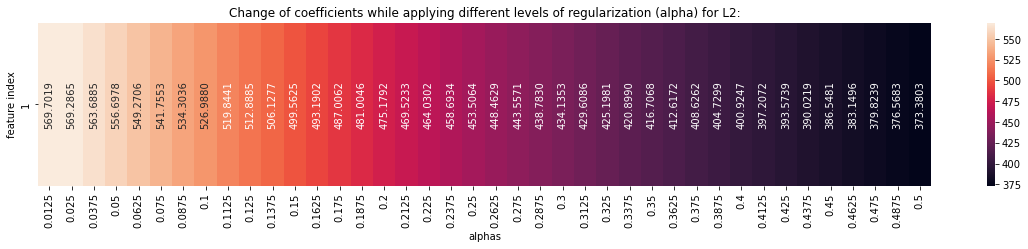

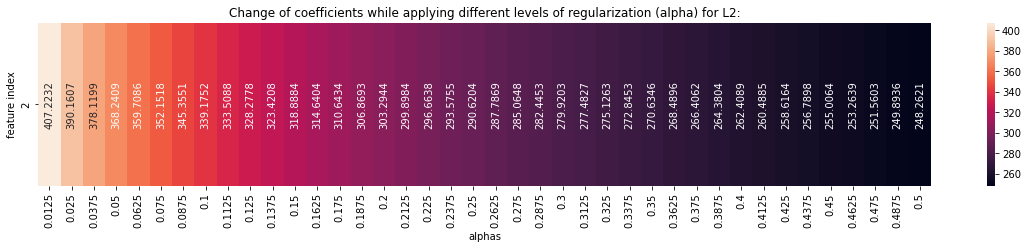

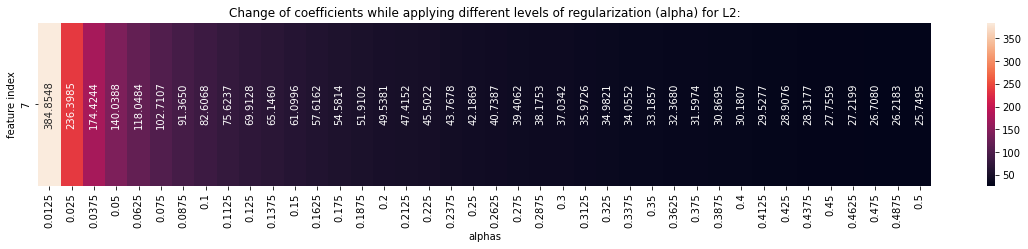

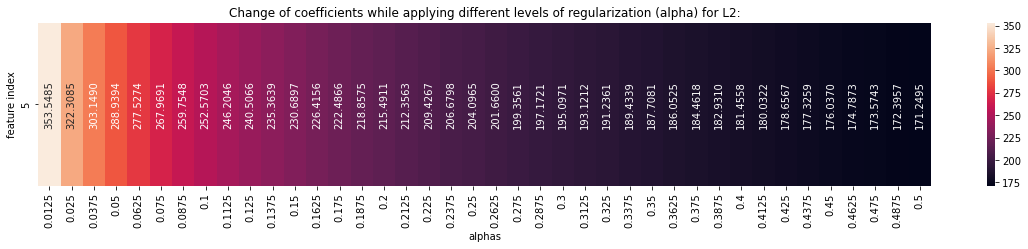

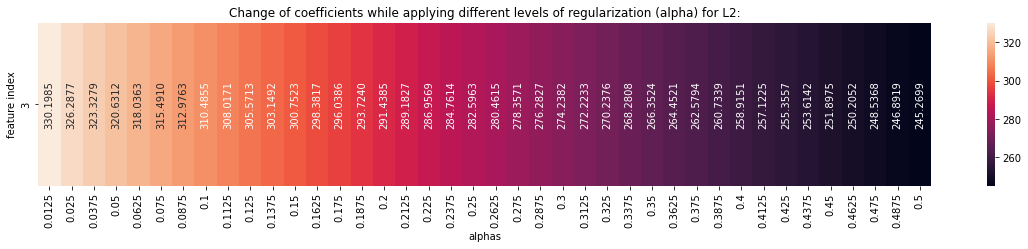

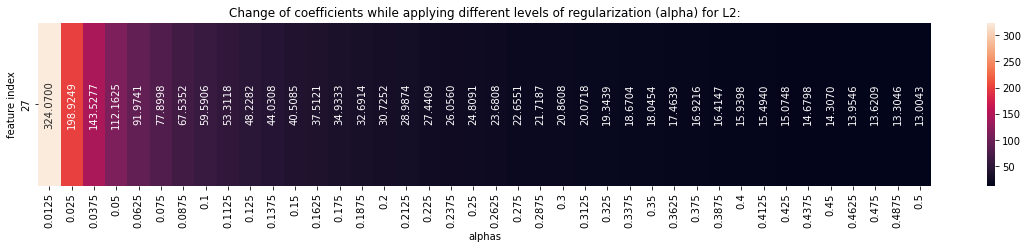

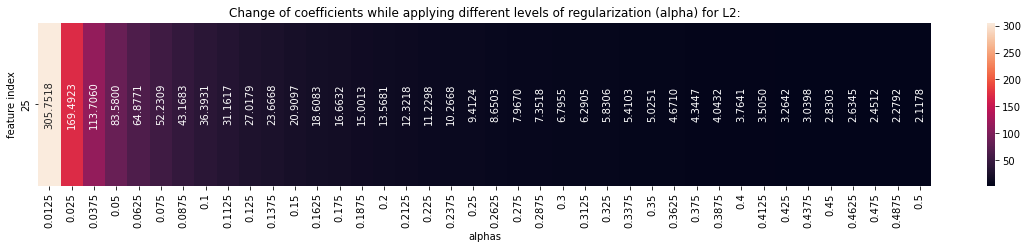

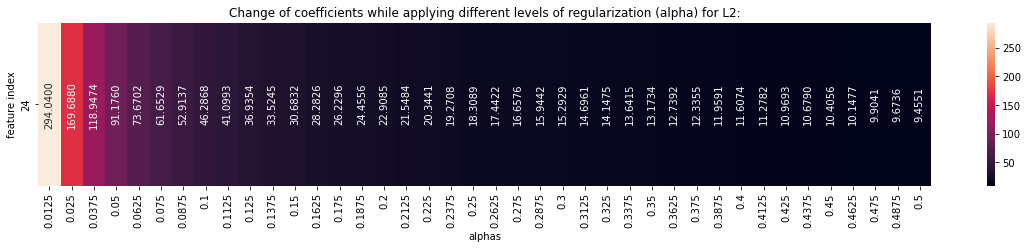

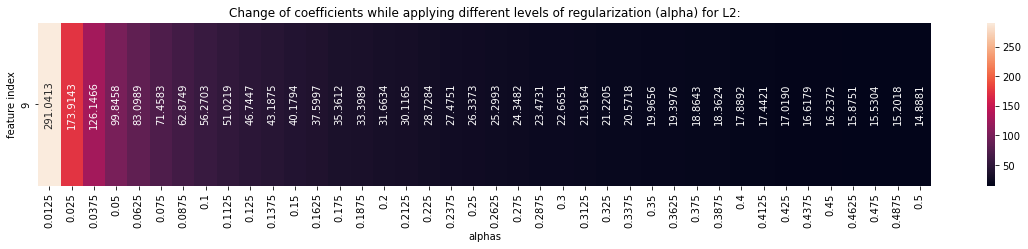

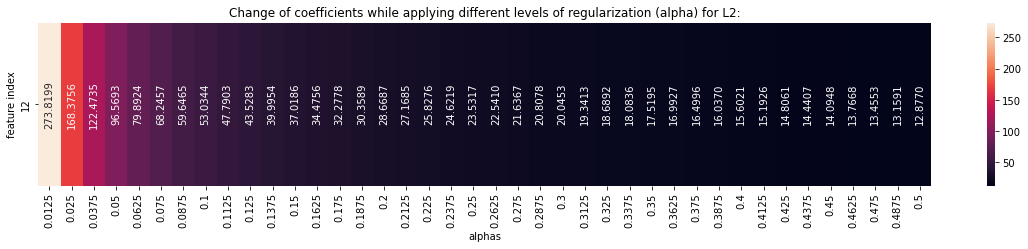

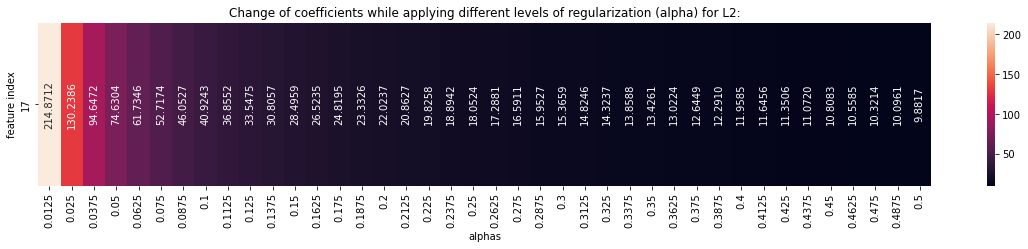

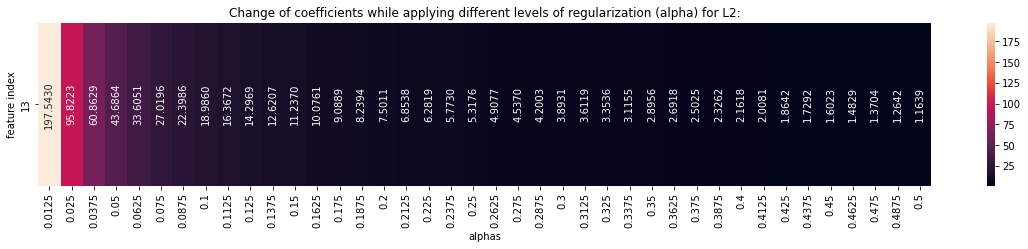

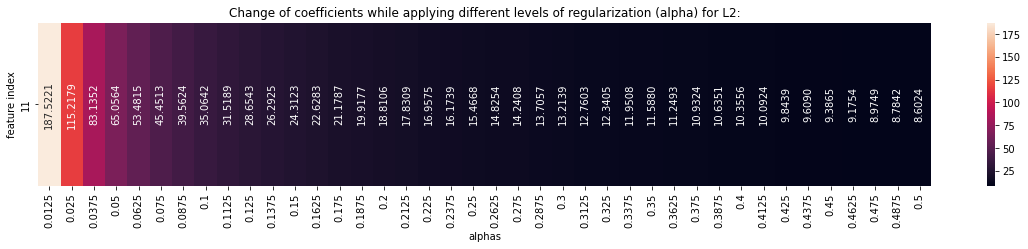

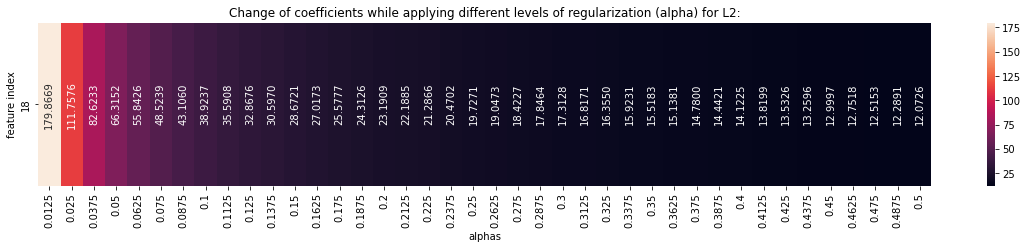

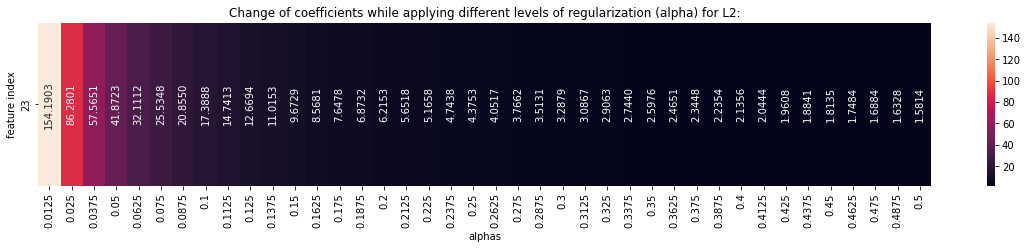

In [47]:
non_null_l2_df = l2_results_df.abs().sort_values(by=0.0125, ascending=False).head(15)
non_null_l2_df.columns = [round(a, 4) for a in ALPHAS[1:]]
display(non_null_l2_df)

for i in range(non_null_l2_df.shape[0]):
    plt.figure(figsize=(20,3))
    sns.heatmap(pd.DataFrame(non_null_l2_df.iloc[i]).T, annot=True, annot_kws={'rotation': 90}, fmt='.4f')
    plt.title('Change of coefficients while applying different levels of regularization (alpha) for L2:')
    plt.xlabel('alphas')
    plt.ylabel('feature index')
    plt.show()

для анализа штафа коэффициентов/магнитуды для L2 отобрали 20 фичей с наибольшими коэффициентами, чтобы посмотреть, как будет происходит регуляризация, в целом динамика аналогичная тому, что происходило при L1, с ростом коэффициента alpha удельные веса фичей снижаются, т.е. получают все больший и больший штраф

при чем некоторые фичи штрафуются сильнее и быстрее теряют свое влияние на таргет, в то время как другие проходят более плавную корректировку веса, что полагаю связано с важностью фичи в предсказании и влиянии на таргет

#### Summary

как итог, можно утверждать, что даже при использовании функцией с высокой степенью полинома можно избежать переобучения применяя регуляризацию

если мы оперируем признаками, которые в действительности могут не иметь связи и зависимости друг с другом, и в целом логическая операция зануления или отбрасывания фичи из рассмотрения может быть применима к модели, то можно воспользоваться L1 - Lasso Regression, L2 Ridge Regression имеет смысл использовать, когда мы не можем утверждать, что фичи друг с другом не связанны и не хотим их полностью убирать из модели

кроме того, стоит отметить, что на том же наборе данных Ridge Regression дает результат чуть выше как раз за счет того, что не зануляет фичи и они суммарно вносят свой вклад, улучшая качество модели, но тут стоит помнить, что этот небольшой прирост достигается в нашем случае сохранением более чем 52 тыс.фичей, действительно ли так важна эта дельта в качестве или важнее производительность модели? - открытый вопрос в зависимости от каждой конкретной модели и ее целей, который стоит иметь в виду

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

воспользуемся полученными ранее датафреймами с коэффициентами для L1 и L2

#### L1

In [48]:
display(l1_results_df.head(15))

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,558.931608,596.967430,594.130857,591.310977,589.728169,588.188956,586.649969,585.110995,583.572021,582.032803,580.491658,578.756741,576.936155,575.115568,573.294982,571.474396,569.653809,567.833223,566.012637,564.192051,562.371464,560.550878,558.730292,556.909705,555.089119,553.268533,551.447947,549.627360,547.806774,545.986188,544.165602,542.345015,540.524429,538.703843,536.883256,535.062670,533.242084,531.421498,529.600911,527.780325
2,404.418773,381.623583,367.504620,353.538235,351.601457,350.265504,348.930866,347.596297,346.261728,344.927570,343.596653,341.885995,340.009531,338.133066,336.256601,334.380136,332.503671,330.627206,328.750741,326.874276,324.997811,323.121347,321.244882,319.368417,317.491952,315.615487,313.739022,311.862557,309.986092,308.109627,306.233163,304.356698,302.480233,300.603768,298.727303,296.850838,294.974373,293.097908,291.221443,289.344979
3,337.523535,325.037473,323.165650,321.280581,318.090326,314.848633,311.607059,308.365491,305.123923,301.882537,298.642579,295.138053,291.495638,287.853224,284.210809,280.568395,276.925981,273.283566,269.641152,265.998737,262.356323,258.713908,255.071494,251.429079,247.786665,244.144251,240.501836,236.859422,233.217007,229.574593,225.932178,222.289764,218.647349,215.004935,211.362521,207.720106,204.077692,200.435277,196.792863,193.150448
4,-122.610625,-70.531661,-35.928805,-1.522788,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-338.955838,-287.026289,-264.061999,-241.177243,-236.828061,-233.333057,-229.837879,-226.342693,-222.847506,-219.352407,-215.857999,-212.214726,-208.486707,-204.758688,-201.030669,-197.302650,-193.574631,-189.846612,-186.118593,-182.390574,-178.662555,-174.934536,-171.206517,-167.478498,-163.750479,-160.022460,-156.294441,-152.566422,-148.838403,-145.110384,-141.382365,-137.654346,-133.926327,-130.198308,-126.470289,-122.742271,-119.014252,-115.286233,-111.558214,-107.830195
6,20.234843,25.593786,19.987302,14.372328,12.284751,10.343482,8.401521,6.459523,4.517526,2.575339,0.631662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1017.831687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,26.844630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [49]:
non_zeros_l1 = np.count_nonzero(l1_results_df, axis=0).tolist()
non_zeros_counts_l1_df = pd.DataFrame(data=[non_zeros_l1], columns=l1_results_df.columns)
non_zeros_counts_l1_df

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,11,6,6,6,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [50]:
display(l1_results_df.shape)

(54264, 40)

в случае с L1 из 54264 фичей уже при применении alpha 0,0125 ненулевые веса остались только у 11 фичей, таким образом, буквально с первого шага было отброшено подавляющее большинство фичей, которые были расценены как не оказывающие существенного влияния, а по итогу начиная с alpha = 0,15 их количество стало равно 4, т.е. L1 действительно может быть использован для отбора фичей

#### L2

In [51]:
display(l2_results_df.head(15))

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,569.701921,569.286525,563.688495,556.697774,549.270603,541.755297,534.303632,526.988034,519.844061,512.888456,506.127720,499.562544,493.190248,487.006194,481.004627,475.179196,469.523288,464.030227,458.693412,453.506398,448.462948,443.557064,438.782997,434.135260,429.608623,425.198110,420.898991,416.706772,412.617186,408.626184,404.729918,400.924738,397.207175,393.573935,390.021889,386.548060,383.149620,379.823875,376.568262,373.380342
2,407.223203,390.160747,378.119926,368.240921,359.708630,352.151836,345.355103,339.175180,333.508834,328.277811,323.420756,318.888388,314.640411,310.643403,306.869325,303.294422,299.898405,296.663816,293.575539,290.620406,287.786886,285.064835,282.445287,279.920284,277.482737,275.126309,272.845313,270.634632,268.489645,266.406172,264.380414,262.408919,260.488533,258.616373,256.789799,255.006383,253.263893,251.560268,249.893606,248.262146
3,330.198541,326.287664,323.327881,320.631160,318.036307,315.490991,312.976271,310.485519,308.017060,305.571252,303.149215,300.752278,298.381715,296.038646,293.723992,291.438481,289.182652,286.956878,284.761386,282.596275,280.461539,278.357078,276.282718,274.238220,272.223292,270.237600,268.280775,266.352419,264.452114,262.579422,260.733894,258.915073,257.122492,255.355685,253.614183,251.897515,250.205216,248.536822,246.891875,245.269920
4,-146.765443,-110.848193,-86.087437,-66.632881,-50.476960,-36.657295,-24.616343,-13.990796,-4.525049,3.970357,11.641146,18.602509,24.947428,30.752213,36.080348,40.985243,45.512268,49.700289,53.582841,57.189053,60.544373,63.671152,66.589115,69.315751,71.866625,74.255645,76.495281,78.596751,80.570180,82.424728,84.168707,85.809680,87.354544,88.809602,90.180627,91.472918,92.691349,93.840409,94.924241,95.946678
5,-353.548450,-322.308511,-303.148997,-288.939449,-277.527392,-267.969098,-259.754771,-252.570329,-246.204570,-240.506612,-235.363899,-230.689723,-226.415641,-222.486571,-218.857494,-215.491140,-212.356319,-209.426685,-206.679808,-204.096451,-201.660014,-199.356089,-197.172107,-195.097053,-193.121227,-191.236060,-189.433947,-187.708121,-186.052536,-184.461780,-182.930989,-181.455781,-180.032201,-178.656669,-177.325935,-176.037046,-174.787309,-173.574268,-172.395675,-171.249469
6,29.922677,38.124627,43.679340,48.225268,52.213406,55.821905,59.138177,62.212365,65.076935,67.754996,70.264241,72.618966,74.831190,76.911301,78.868461,80.710871,82.445942,84.080429,85.620519,87.071906,88.439847,89.729210,90.944514,92.089957,93.169451,94.186644,95.144940,96.047524,96.897375,97.697284,98.449867,99.157580,99.822728,100.447480,101.033875,101.583831,102.099156,102.581555,103.032636,103.453914
7,384.854842,236.398462,174.424442,140.038830,118.048359,102.710696,91.364991,82.606757,75.623680,69.912844,65.145993,61.099621,57.616186,54.581380,51.910207,49.538120,47.415196,45.502197,43.767840,42.186870,40.738665,39.406209,38.175338,37.034154,35.972591,34.982070,34.055231,33.185723,32.368033,31.597354,30.869470,30.180669,29.527670,28.907559,28.317738,27.755888,27.219923,26.707970,26.218336,25.749489
8,29.457088,35.818787,31.462734,27.326969,24.055011,21.491356,19.451002,17.795588,16.427886,15.279558,14.301798,13.459051,12.724906,12.079374,11.507070,10.995972,10.536552,10.121166,9.743611,9.398801,9.082526,8.791274,8.522088,8.272464,8.040265,7.823657,7.621057,7.431092,7.252564,7.084423,6.925744,6.775714,6.633607,6.49

In [52]:
non_zeros_l2 = np.count_nonzero(l2_results_df, axis=0).tolist()
non_zeros_counts_l2_df = pd.DataFrame(data=[non_zeros_l2], columns=l2_results_df.columns)
non_zeros_counts_l2_df

,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263,54263


,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,54138,54171,54188,54196,54203,54209,54212,54213,54215,54218,54220,54220,54221,54222,54225,54227,54228,54228,54229,54229,54230,54230,54230,54230,54230,54230,54230,54230,54230,54230,54231,54231,54231,54231,54231,54231,54231,54231,54232,54232


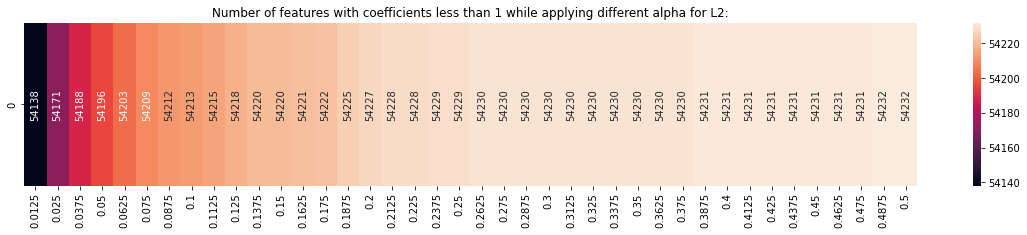

In [53]:
less_than_one_l2 = []
for col in l2_results_df.columns:
    less_than_one_l2.append(np.sum(l2_results_df[col].abs() < 1))
alpha_columns = [round(a, 4) for a in ALPHAS[1:]]
less_than_one_l2_df = pd.DataFrame(data=[less_than_one_l2], columns=alpha_columns)
display(less_than_one_l2_df)

plt.figure(figsize=(20,3))
sns.heatmap(less_than_one_l2_df, annot=True, annot_kws={'rotation': 90}, fmt='.0f')
plt.title('Number of features with coefficients less than 1 while applying different alpha for L2:')
plt.show()

при L2 все фичи (первый 0 это intercept) учитываются моделью на каждом этапе, ни одна не убирается из рассмотрения, хотя и происходит существенное снижение веса для подавляющего большинства фичей, которые модель посчитала неважными: так можно заметить, что большая часть фичей имеет вес меньше единицы, таким образом модель снижает их влияние

#### Summary

в добавление ко всем выше описанным выводам можно добавить, что действительно в силу того, что при L1 происходит зануление неважных фичей, можно воспользоваться таким походом для отбора фичей для модели или как минимум оптимизации и поиска фичей, не оказывающих существенного влияния на таргет

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [54]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [55]:
display(X_hw[:5])
display(y_hw[:5])

array([[-1.25459881e-02, -3.84945434e+02,  8.06670932e+01],
       [ 4.50714306e-02,  1.09066539e+02,  1.82952436e+02],
       [ 2.31993942e-02, -3.66609036e+02, -2.35345655e+00],
       [ 9.86584842e-03, -2.59410380e+02,  1.69965849e+02],
       [-3.43981360e-02, -1.72860944e+02,  6.60496439e+01]])

array([  3.55656885,   2.47815805,  11.76776244,  -0.49774112,
       -11.22522436])

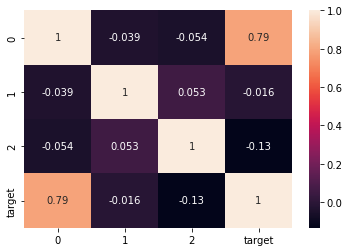

In [56]:
hw_df = pd.DataFrame(X_hw)
hw_df['target'] = pd.Series(y_hw)
sns.heatmap(hw_df.corr(), annot=True)
plt.show()

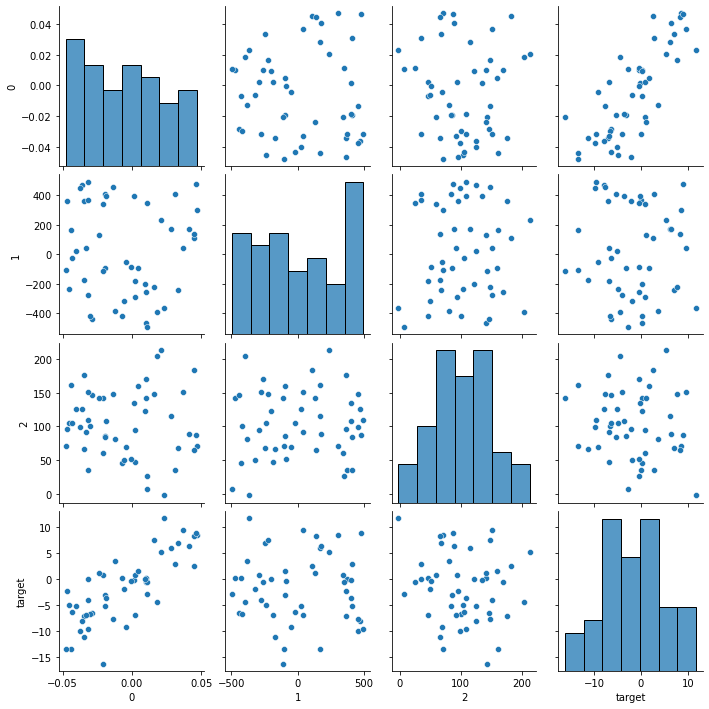

In [57]:
sns.pairplot(hw_df)
plt.show()

наибольшую корреляцию с таргетом имеет фича с индексом 0, есть некоторая зависимость с фичей под индексом 2, и крайне слабая, практически отсутствующая связь с фичей под индексом 1

In [58]:
X_hw_train, X_hw_test, y_hw_train, y_hw_test = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

print(f'Train features: {X_hw_train.shape}')
print(f'Train targe: {y_hw_train.shape}\n')

print(f'Test features: {X_hw_test.shape}')
print(f'Test targe: {y_hw_test.shape}')

Train features: (35, 3)
Train targe: (35,)

Test features: (15, 3)
Test targe: (15,)


для сравнения обучим модели без скейлинга и после скейлинга

#### L1

In [59]:
non_scaled_train_l1 = []
non_scaled_test_l1 = []
non_scales_coefficients = []

for a in ALPHAS[1:]:
    l1_model = Lasso(alpha=a)
    l1_model.fit(X_hw_train, y_hw_train)
    
    train_predicted = l1_model.predict(X_hw_train)
    test_predicted = l1_model.predict(X_hw_test)
    
    rmse_train = mean_squared_error(y_hw_train, train_predicted) ** 0.5
    rmse_test = mean_squared_error(y_hw_test, test_predicted) ** 0.5
    diff_pct = rmse_test / rmse_train - 1
    
    non_scaled_train_l1.append(rmse_train)
    non_scaled_test_l1.append(rmse_test)
    non_scales_coefficients.append(l1_model.coef_.tolist())
    
    print(f'Current alpha is {a:.4f}, RMSE on train is {rmse_train:.4f}, RMSE on test is {rmse_test:.4f}, difference is {diff_pct:.2%}.')

Current alpha is 0.0125, RMSE on train is 4.0938, RMSE on test is 4.0950, difference is 0.03%.
Current alpha is 0.0250, RMSE on train is 4.1563, RMSE on test is 4.1619, difference is 0.13%.
Current alpha is 0.0375, RMSE on train is 4.2585, RMSE on test is 4.2544, difference is -0.10%.
Current alpha is 0.0500, RMSE on train is 4.3976, RMSE on test is 4.3710, difference is -0.61%.
Current alpha is 0.0625, RMSE on train is 4.5703, RMSE on test is 4.5097, difference is -1.32%.
Current alpha is 0.0750, RMSE on train is 4.7728, RMSE on test is 4.6686, difference is -2.18%.
Current alpha is 0.0875, RMSE on train is 5.0016, RMSE on test is 4.8458, difference is -3.12%.
Current alpha is 0.1000, RMSE on train is 5.2532, RMSE on test is 5.0391, difference is -4.07%.
Current alpha is 0.1125, RMSE on train is 5.5245, RMSE on test is 5.2470, difference is -5.02%.
Current alpha is 0.1250, RMSE on train is 5.8128, RMSE on test is 5.4677, difference is -5.94%.
Current alpha is 0.1375, RMSE on train is 

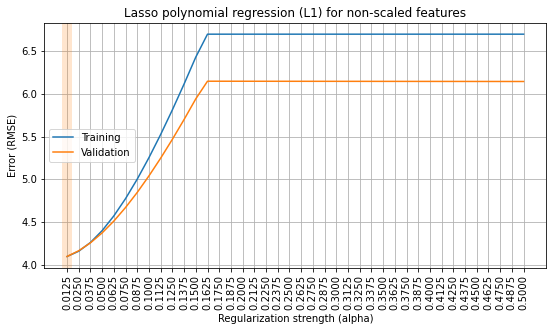

In [60]:
plot_fitting_graph(ALPHAS[1:], non_scaled_train_l1, non_scaled_test_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1) for non-scaled features')

что интересно с alpha начиная от 0,1 можно говорить о том, что регуляризация сглаживает данные на столько, что начинает страдать качество, растет величина ошибки и разрыв с тестом, посмотрим на коэффициенты

In [61]:
non_scaled_l1_coefs = pd.DataFrame(data=non_scales_coefficients, index=ALPHAS[1:])
non_scaled_l1_coefs

,0,1,2
0.0125,162.742716,-0.001072,-0.027332
0.0250,148.980317,-0.001104,-0.027937
0.0375,135.217918,-0.001135,-0.028542
0.0500,121.455518,-0.001167,-0.029147
0.0625,107.693119,-0.001198,-0.029751
0.0750,93.930720,-0.001230,-0.030356
0.0875,80.168321,-0.001261,-0.030961
0.1000,66.405922,-0.001293,-0.031566
0.1125,52.643523,-0.001324,-0.032171
0.1250,38.881123,-0.001356,-0.032776


In [62]:
pd.DataFrame(X_hw).describe()

,0,1,2
count,50.000000,50.000000,50.000000
mean,-0.005408,17.653320,103.135378
std,0.028888,312.157148,49.787228
min,-0.047942,-494.870451,-2.353457
25%,-0.031623,-243.607950,67.572919
50%,-0.006395,0.426019,99.530790
75%,0.014985,347.510534,142.353309
max,0.046991,493.572492,213.314635


для начала стоит отметить, что сами фичи находятся в разных диапазонах, например первая фича принимает крайне малые значения и максимальное не превышает 0,05

вторая фича имеет очень большой разброс данных при среднем 17,65 стандартное отклонение равно 312,16, а последний квартиль содержит значения, которые выше даже максимального по третьей фиче, у которой среднее в ~5 раз выше,

третья вглядит более центрированной вокруг среднего, но общий масштаб значиально больше предыдуших фичей,

и как итог модель пытается уравновесить этот разброс при помощи коэффициентов, давая первой фиче крайне большой коэффициент, 
также пробуя уравновесь аномально большие значения у второй фичи дает ей минимальный коэффициент, и немного чуть больший для третьей, 

в текущем варианте создается ощущение, что разные признаки в силу масшитаба более или менее важны, хотя это может быть не правдой, а причина может заключаться в единицах измерения или размерности, т.е. не означает низкое влияние, но модель это не поймет, попробуем поскейлить фичи и посмотрим на результаты

In [63]:
scaler = StandardScaler()
X_hw_train_scaled = scaler.fit_transform(X_hw_train)
X_hw_test_scaled = scaler.transform(X_hw_test)

In [64]:
scaled_train_l1 = []
scaled_test_l1 = []
scales_coefficients = []

for a in ALPHAS[1:]:
    l1_model = Lasso(alpha=a)
    l1_model.fit(X_hw_train_scaled, y_hw_train)
    
    train_predicted = l1_model.predict(X_hw_train_scaled)
    test_predicted = l1_model.predict(X_hw_test_scaled)
    
    rmse_train = mean_squared_error(y_hw_train, train_predicted) ** 0.5
    rmse_test = mean_squared_error(y_hw_test, test_predicted) ** 0.5
    diff_pct = rmse_test / rmse_train - 1
    
    scaled_train_l1.append(rmse_train)
    scaled_test_l1.append(rmse_test)
    scales_coefficients.append(l1_model.coef_.tolist())
    
    print(f'Current alpha is {a:.4f}, RMSE on train is {rmse_train:.4f}, RMSE on test is {rmse_test:.4f}, difference is {diff_pct:.2%}.')

Current alpha is 0.0125, RMSE on train is 4.0727, RMSE on test is 4.0436, difference is -0.71%.
Current alpha is 0.0250, RMSE on train is 4.0729, RMSE on test is 4.0324, difference is -1.00%.
Current alpha is 0.0375, RMSE on train is 4.0732, RMSE on test is 4.0212, difference is -1.28%.
Current alpha is 0.0500, RMSE on train is 4.0735, RMSE on test is 4.0101, difference is -1.56%.
Current alpha is 0.0625, RMSE on train is 4.0740, RMSE on test is 3.9990, difference is -1.84%.
Current alpha is 0.0750, RMSE on train is 4.0746, RMSE on test is 3.9881, difference is -2.12%.
Current alpha is 0.0875, RMSE on train is 4.0752, RMSE on test is 3.9772, difference is -2.41%.
Current alpha is 0.1000, RMSE on train is 4.0760, RMSE on test is 3.9664, difference is -2.69%.
Current alpha is 0.1125, RMSE on train is 4.0769, RMSE on test is 3.9557, difference is -2.97%.
Current alpha is 0.1250, RMSE on train is 4.0779, RMSE on test is 3.9451, difference is -3.26%.
Current alpha is 0.1375, RMSE on train i

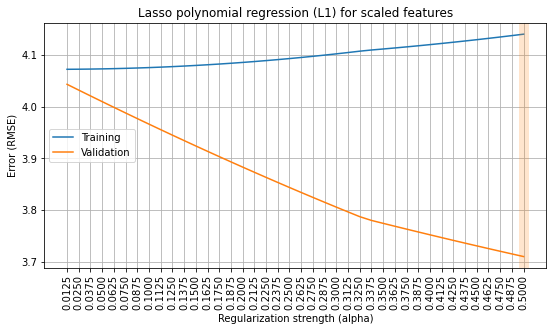

In [65]:
plot_fitting_graph(ALPHAS[1:], scaled_train_l1, scaled_test_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1) for scaled features')

пусть расхождение в % с ростом alpha на более высоких его значениях даже выше, но величина ошибки RMSE по отскейлнным данным значительно ниже, на тесте практически в два раза, посмотрим на коэффициенты

In [66]:
scaled_l1_coefs = pd.DataFrame(data=scales_coefficients, index=ALPHAS[1:])
scaled_l1_coefs

,0,1,2
0.0125,5.324166,-0.296106,-1.328466
0.0250,5.312796,-0.284477,-1.317417
0.0375,5.301426,-0.272848,-1.306367
0.0500,5.290057,-0.261220,-1.295318
0.0625,5.278687,-0.249591,-1.284268
0.0750,5.267318,-0.237962,-1.273219
0.0875,5.255948,-0.226333,-1.262169
0.1000,5.244579,-0.214704,-1.251120
0.1125,5.233209,-0.203075,-1.240070
0.1250,5.221840,-0.191446,-1.229021


In [67]:
pd.concat([pd.DataFrame(X_hw_train_scaled), pd.DataFrame(X_hw_test_scaled)]).reset_index(drop=True).describe()

,0,1,2
count,50.000000,50.000000,50.000000
mean,-0.006408,-0.297357,-0.021891
std,0.955656,1.055362,0.993404
min,-1.413475,-2.030132,-2.126709
25%,-0.873650,-1.180646,-0.731469
50%,-0.039076,-0.355600,-0.093813
75%,0.668217,0.817847,0.760624
max,1.726993,1.311663,2.176515


теперь все фичи имеют примерно одинаковую размерность, размещены в пределах одного диапазона данных, и теперь модель подбирает коэффициенты исходя из зависимостей в данных - реального вклада фичи в предсказание таргета, что интересно, модель теперь не зануляет первый признак, напротив он оказался наиболее важным

#### L2

In [68]:
non_scaled_train_l2 = []
non_scaled_test_l2 = []
non_scaled_coefficients_l2 = []

for a in ALPHAS[1:]:
    l2_model = Ridge(alpha=a)
    l2_model.fit(X_hw_train, y_hw_train)
    
    train_predicted = l2_model.predict(X_hw_train)
    test_predicted = l2_model.predict(X_hw_test)
    
    rmse_train = mean_squared_error(y_hw_train, train_predicted) ** 0.5
    rmse_test = mean_squared_error(y_hw_test, test_predicted) ** 0.5
    diff_pct = rmse_test / rmse_train - 1
    
    non_scaled_train_l2.append(rmse_train)
    non_scaled_test_l2.append(rmse_test)
    non_scaled_coefficients_l2.append(l2_model.coef_.tolist())
    
    print(f'Current alpha is {a:.4f}, RMSE on train is {rmse_train:.4f}, RMSE on test is {rmse_test:.4f}, difference is {diff_pct:.2%}.')

Current alpha is 0.0125, RMSE on train is 4.3406, RMSE on test is 4.3245, difference is -0.37%.
Current alpha is 0.0250, RMSE on train is 4.6979, RMSE on test is 4.6111, difference is -1.85%.
Current alpha is 0.0375, RMSE on train is 4.9875, RMSE on test is 4.8359, difference is -3.04%.
Current alpha is 0.0500, RMSE on train is 5.2117, RMSE on test is 5.0084, difference is -3.90%.
Current alpha is 0.0625, RMSE on train is 5.3869, RMSE on test is 5.1428, difference is -4.53%.
Current alpha is 0.0750, RMSE on train is 5.5266, RMSE on test is 5.2498, difference is -5.01%.
Current alpha is 0.0875, RMSE on train is 5.6401, RMSE on test is 5.3368, difference is -5.38%.
Current alpha is 0.1000, RMSE on train is 5.7339, RMSE on test is 5.4086, difference is -5.67%.
Current alpha is 0.1125, RMSE on train is 5.8127, RMSE on test is 5.4690, difference is -5.91%.
Current alpha is 0.1250, RMSE on train is 5.8798, RMSE on test is 5.5203, difference is -6.11%.
Current alpha is 0.1375, RMSE on train i

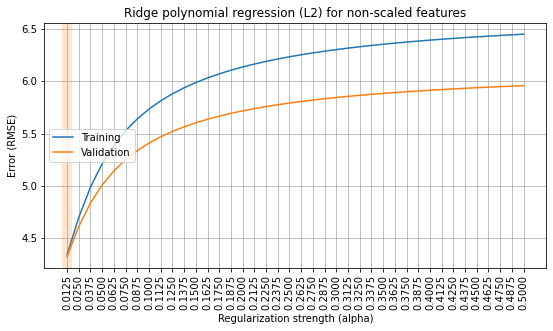

In [69]:
plot_fitting_graph(ALPHAS[1:], non_scaled_train_l2, non_scaled_test_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2) for non-scaled features')

In [70]:
non_scaled_l2_coefs = pd.DataFrame(data=non_scaled_coefficients_l2, index=ALPHAS[1:])
non_scaled_l2_coefs

,0,1,2
0.0125,126.687735,-0.001155,-0.028935
0.0250,98.801637,-0.001219,-0.030170
0.0375,80.977196,-0.001260,-0.030960
0.0500,68.601120,-0.001289,-0.031508
0.0625,59.506499,-0.001309,-0.031911
0.0750,52.541006,-0.001325,-0.032220
0.0875,47.035320,-0.001338,-0.032464
0.1000,42.574054,-0.001348,-0.032661
0.1125,38.885767,-0.001357,-0.032825
0.1250,35.785581,-0.001364,-0.032962


в целом такая же ситуация как и с L1, только с характерными особенностями L2 - не зануляются признаки, как итог предсказание в целом немного точнее за счет учета всех признаков, но модель все так же пытается компенсировать разный маштаб, что приводит к непропорциональным коэффициентам, посмотрим на L2 для отскейленных данных

In [71]:
scaled_train_l2 = []
scaled_test_l2 = []
scaled_coefficients_l2 = []

for a in ALPHAS[1:]:
    l2_model = Ridge(alpha=a)
    l2_model.fit(X_hw_train_scaled, y_hw_train)
    
    train_predicted = l2_model.predict(X_hw_train_scaled)
    test_predicted = l2_model.predict(X_hw_test_scaled)
    
    rmse_train = mean_squared_error(y_hw_train, train_predicted) ** 0.5
    rmse_test = mean_squared_error(y_hw_test, test_predicted) ** 0.5
    diff_pct = rmse_test / rmse_train - 1
    
    scaled_train_l2.append(rmse_train)
    scaled_test_l2.append(rmse_test)
    scaled_coefficients_l2.append(l2_model.coef_.tolist())
    
    print(f'Current alpha is {a:.4f}, RMSE on train is {rmse_train:.4f}, RMSE on test is {rmse_test:.4f}, difference is {diff_pct:.2%}.')

Current alpha is 0.0125, RMSE on train is 4.0727, RMSE on test is 4.0548, difference is -0.44%.
Current alpha is 0.0250, RMSE on train is 4.0727, RMSE on test is 4.0546, difference is -0.44%.
Current alpha is 0.0375, RMSE on train is 4.0727, RMSE on test is 4.0544, difference is -0.45%.
Current alpha is 0.0500, RMSE on train is 4.0727, RMSE on test is 4.0542, difference is -0.45%.
Current alpha is 0.0625, RMSE on train is 4.0727, RMSE on test is 4.0540, difference is -0.46%.
Current alpha is 0.0750, RMSE on train is 4.0727, RMSE on test is 4.0538, difference is -0.46%.
Current alpha is 0.0875, RMSE on train is 4.0727, RMSE on test is 4.0536, difference is -0.47%.
Current alpha is 0.1000, RMSE on train is 4.0727, RMSE on test is 4.0534, difference is -0.47%.
Current alpha is 0.1125, RMSE on train is 4.0727, RMSE on test is 4.0532, difference is -0.48%.
Current alpha is 0.1250, RMSE on train is 4.0727, RMSE on test is 4.0530, difference is -0.48%.
Current alpha is 0.1375, RMSE on train i

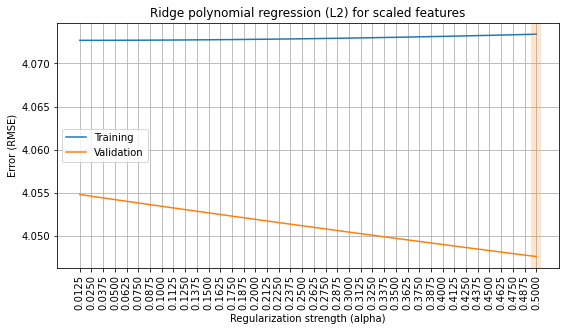

In [72]:
plot_fitting_graph(ALPHAS[1:], scaled_train_l2, scaled_test_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2) for scaled features')

ошибка на отскейленных данных также снизилась, но что инетересно - разбежка между трейном и тестом минимальная - менее 1%, чего не было при L1, посмотрим на коэффициенты при L2

In [73]:
scaled_l2_coefs = pd.DataFrame(data=scaled_coefficients_l2, index=ALPHAS[1:])
scaled_l2_coefs

,0,1,2
0.0125,5.333657,-0.307692,-1.339180
0.0250,5.331779,-0.307649,-1.338844
0.0375,5.329903,-0.307606,-1.338508
0.0500,5.328029,-0.307563,-1.338173
0.0625,5.326155,-0.307519,-1.337838
0.0750,5.324283,-0.307476,-1.337503
0.0875,5.322412,-0.307433,-1.337168
0.1000,5.320543,-0.307390,-1.336833
0.1125,5.318675,-0.307347,-1.336498
0.1250,5.316808,-0.307304,-1.336163


коэффициенты после скейлинга примерно те же, что и при использовании L1, но интересно то, что все коэффициенты считаются важными и ни один не был существенно понижен, полагаю это и есть причина такой малой разбежки по качеству между трейном и тестом

#### Summary



в целом относительно скейлинга можно сказать, что этот процесс позволяет убрать эффект масштаба, из-за которого одна фича может казаться важнее другой просто в силу того, что величина измерения, сами значения в абсолютном выражении выше, чем у других фичей, что не учитывает их реальный вклад и зависимости между фичами и таргетом, кроме того в таком варианте модели больше заняты компенсацией этого размера и поиском зависимости по масштабу, что по сути не верно, скейлинг приводит все к одному масштабу и в итоге остаются только данные и их реальные связи с таргетом